## Importing the Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import time
import random
import graphviz
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow.keras.regularizers as regularizer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier

random.seed(1337)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Cleaning Up the Data:

In [2]:
'''Reading data'''
data = pd.read_csv("HDHI Admission Data.csv")
data.head(3)

,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [3]:
column_names = data.keys()

'''Making column names into lower case'''
column_names = [s.lower() for s in column_names]
print("Features Before Cleaning:\n\n ", column_names, end = " ")
data.set_axis(column_names, axis = 1, inplace = True)
data.head(3)

Features Before Cleaning:

  ['sno', 'mrd no.', 'd.o.a', 'd.o.d', 'age', 'gender', 'rural', 'type of admission-emergency/opd', 'month year', 'duration of stay', 'duration of intensive unit stay', 'outcome', 'smoking ', 'alcohol', 'dm', 'htn', 'cad', 'prior cmp', 'ckd', 'hb', 'tlc', 'platelets', 'glucose', 'urea', 'creatinine', 'bnp', 'raised cardiac enzymes', 'ef', 'severe anaemia', 'anaemia', 'stable angina', 'acs', 'stemi', 'atypical chest pain', 'heart failure', 'hfref', 'hfnef', 'valvular', 'chb', 'sss', 'aki', 'cva infract', 'cva bleed', 'af', 'vt', 'psvt', 'congenital', 'uti', 'neuro cardiogenic syncope', 'orthostatic', 'infective endocarditis', 'dvt', 'cardiogenic shock', 'shock', 'pulmonary embolism', 'chest infection'] 

,sno,mrd no.,d.o.a,d.o.d,age,gender,rural,type of admission-emergency/opd,month year,duration of stay,...,congenital,uti,neuro cardiogenic syncope,orthostatic,infective endocarditis,dvt,cardiogenic shock,shock,pulmonary embolism,chest infection
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
'''Deleting uncessary features'''

uncessary_features = ["sno", "mrd no.", "d.o.a", "month year"]
if "sno" in data.keys():
    data.drop(uncessary_features, axis = 1, inplace = True)
    
data.head(3)

,d.o.d,age,gender,rural,type of admission-emergency/opd,duration of stay,duration of intensive unit stay,outcome,smoking,alcohol,...,congenital,uti,neuro cardiogenic syncope,orthostatic,infective endocarditis,dvt,cardiogenic shock,shock,pulmonary embolism,chest infection
0,4/3/2017,81,M,R,E,3,2,DISCHARGE,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4/5/2017,65,M,R,E,5,2,DISCHARGE,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4/3/2017,53,M,U,E,3,3,DISCHARGE,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
'''Replacing empty cells with zero'''

data.fillna(0, inplace = True)
data.replace("EMPTY", 0, inplace = True)


'''Clarifying column's names'''

#"total leucocyte count"  "myocardial infarction"
unclear_features = ["d.o.d", "dm", "htn", "cad", "prior cmp","ckd", "ef", "tlc", "bnp", "stemi", "hfref", "hfnef", "chb", "sss",
                    "aki","cva infract", "cva bleed", "af", "vt", "psvt", "uti", "dvt"]

clear_features = ["date of admission", "diabetes mellitus", "hypertension", "coronary artery disease", "prior metabolic panel",
                  "chronic kidney disease","ejection fraction", "leucocyte count", "brain natriuretic peptide", 
                  "myocardial infarction", "heart failure w/ reduced ejection","heart failure w/ normal ejection", "heart block", 
                  "sick sinus", "kidney injury", "cerebrovascular accident", "cerebrovascular accident",
                  "atrial fibrillation","ventricular tachycardia", "paroxysmal tachycardia",
                  "urinary tract infections", "vein thrombosis"]

for i in range(len(unclear_features)):
    data.rename(columns = {unclear_features[i] : clear_features[i]}, inplace = True)

if "shock" in data.keys():
    data.drop(["shock"], axis = 1, inplace = True)
    
print("Cleared Features:\n ")
print(data.keys())
print("\nTotal features: ", len(data.keys()))

Cleared Features:
 
Index(['date of admission', 'age', 'gender', 'rural',
       'type of admission-emergency/opd', 'duration of stay',
       'duration of intensive unit stay', 'outcome', 'smoking ', 'alcohol',
       'diabetes mellitus', 'hypertension', 'coronary artery disease',
       'prior metabolic panel', 'chronic kidney disease', 'hb',
       'leucocyte count', 'platelets', 'glucose', 'urea', 'creatinine',
       'brain natriuretic peptide', 'raised cardiac enzymes',
       'ejection fraction', 'severe anaemia', 'anaemia', 'stable angina',
       'acs', 'myocardial infarction', 'atypical chest pain', 'heart failure',
       'heart failure w/ reduced ejection', 'heart failure w/ normal ejection',
       'valvular', 'heart block', 'sick sinus', 'kidney injury',
       'cerebrovascular accident', 'cerebrovascular accident',
       'atrial fibrillation', 'ventricular tachycardia',
       'paroxysmal tachycardia', 'congenital', 'urinary tract infections',
       'neuro cardiogenic 

In [6]:
'''Normalizing features'''

features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
           "ejection fraction", "duration of intensive unit stay"]


'''Original values will be stored in case they are needed in the future'''

original_vals = list()
stand_vals = list()
normalizer = MinMaxScaler()

for i in range(len(features)):
    
    original_vals.append(data[features[i]].values)
    
    stand_temp = normalizer.fit_transform(data[features[i]].astype("float64").values.reshape(-1,1))
    
    stand_vals.append(stand_temp.copy())
    data[features[i]] = stand_temp.copy()
  

## Starting with prediction process:

Error Margin with most_frequent  Strategy:  47.94945008460237


Error Margin with stratified  Strategy:  51.834179357021995


Error Margin with prior  Strategy:  47.94945008460237


For Testing Dataset:
 


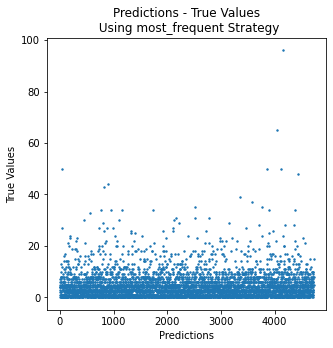

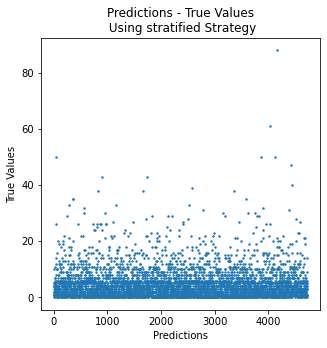

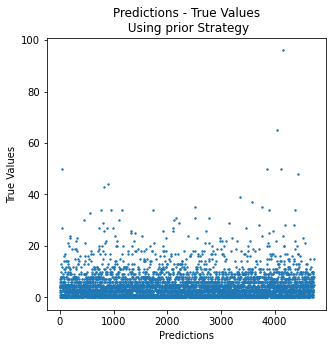

In [1022]:

"""Using DummyClassifier to predict the length of stay at the hospital"""

label = "duration of stay"
features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide"]
strategies = ["most_frequent", "stratified", "prior"]
predictions = list()

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)
for strat in strategies:
    
    dummy_classifier = DummyClassifier(strategy = strat)
    result = dummy_classifier.fit(train_x, train_y)
    prediction = result.predict(test_x)
    predictions.append(prediction)
    print(f"Error Margin with {strat}  Strategy: ", mean_squared_error(prediction, test_y))
    print("\n")
    
'''Plotting difference between predictions and true values'''

print("For Testing Dataset:\n ")

for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {strategies[i]} Strategy")
    plt.xlabel("Predictions")
    plt.ylabel("True Values")
    plt.scatter(np.arange(0, len(predictions[i])) ,abs(predictions[i] - test_y), s = 2)

Training Error Margin with gini  Criterion:  26.528787741409012
Testing Error Margin with gini  Criterion:  30.54251269035533


Training Error Margin with entropy  Criterion:  27.99011696436667
Testing Error Margin with entropy  Criterion:  32.252326565143825


For Testing Dataset:
 


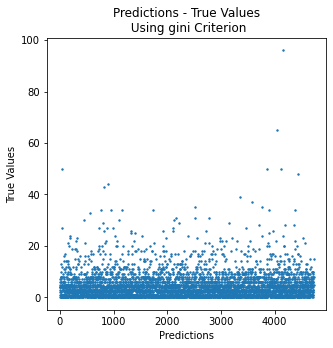

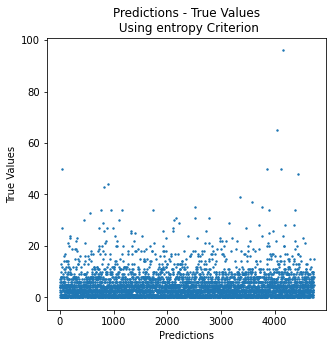

In [1023]:
'''Using DecisionTreeClassifier'''

"""Using DecisionClassifier to predict the length of stay at the hospital"""

criterions = ["gini", "entropy"]
predictions = list()

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

for crit in criterions:
    
    decision_classifier = DecisionTreeClassifier(criterion = crit, max_depth = 7)
    result = decision_classifier.fit(train_x, train_y)
    prediction_tr = result.predict(train_x)
    prediction_te = result.predict(test_x)
    predictions.append(prediction)
    
 
    print(f"Training Error Margin with {crit}  Criterion: ", mean_squared_error(prediction_tr, train_y))
    print(f"Testing Error Margin with {crit}  Criterion: ", mean_squared_error(prediction_te, test_y))
    print("\n")
    
'''Plotting difference between testing predictions and true values'''

print("For Testing Dataset:\n ")

for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {criterions[i]} Criterion")
    plt.xlabel("Predictions")
    plt.ylabel("True Values")
    plt.scatter(np.arange(0, len(predictions[i])) ,abs(predictions[i] - test_y), s = 2)



Training Average CV Score:  0.13120205257981676
Testing Average CV Score:  0.05681067955822463
Training Error Margin with 20  Estimators:  12.824891062003012
Testing Error Margin with 20  Estimators:  23.81606480692489


Training Average CV Score:  0.1379420790515616
Testing Average CV Score:  0.06770608780120033
Training Error Margin with 30  Estimators:  12.602424366801818
Testing Error Margin with 30  Estimators:  23.76358207275494


Training Average CV Score:  0.14079341981794058
Testing Average CV Score:  0.0672814034565001
Training Error Margin with 40  Estimators:  12.553110227842684
Testing Error Margin with 40  Estimators:  23.710389483109523


Training Average CV Score:  0.14132270887445214
Testing Average CV Score:  0.06966740962109945
Training Error Margin with 50  Estimators:  12.576795652986622
Testing Error Margin with 50  Estimators:  23.701644927184336


Training Average CV Score:  0.14260278672572196
Testing Average CV Score:  0.07154594120411384
Training Error Margin

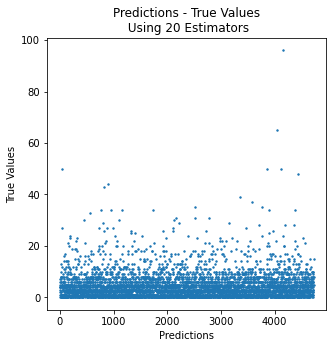

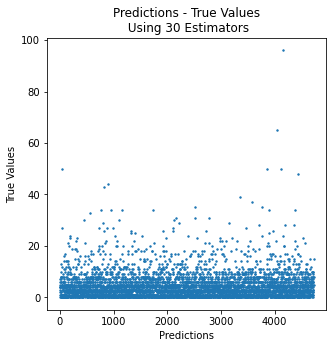

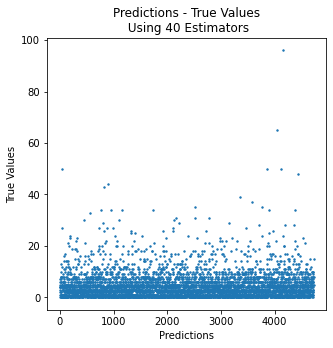

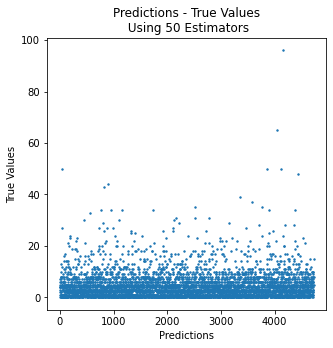

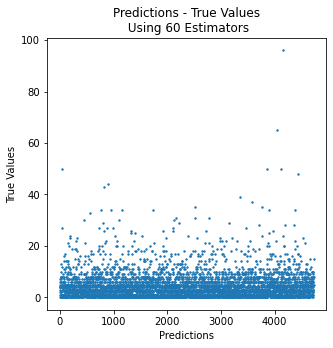

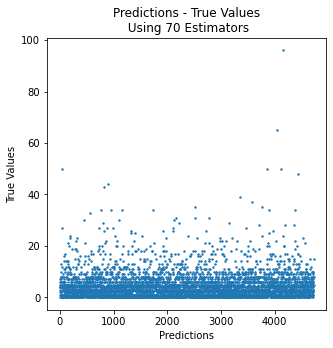

In [1024]:
'''Using RandomForests'''

"""Using RandomForests to predict the length of stay at the hospital"""

estimators = [20, 30, 40 ,50 ,60, 70]
predictions = list()

label = "duration of stay"
features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide"]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)
training_scores = list()
testing_scores = list()

for estim in estimators:
    
    forest_classifier = RandomForestRegressor(n_estimators = estim,  max_depth = 10, n_jobs = -1, random_state = 1337)
    result = forest_classifier.fit(train_x, train_y)
    prediction_tr = result.predict(train_x).astype("float64")
    prediction_te = result.predict(test_x).astype("float64")
    predictions.append(prediction)
    
    training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
    testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)
    training_scores.append(training_cv_scores.copy())
    testing_scores.append(testing_cv_scores.copy())
    
    print("Training Average CV Score: ", np.average(training_cv_scores))
    print("Testing Average CV Score: ", np.average(testing_cv_scores))
    
    print(f"Training Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_tr, train_y))
    print(f"Testing Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")
    
'''Plotting difference between testing predictions and true values'''

print("For Testing Dataset:\n ")

for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {estimators[i]} Estimators")
    plt.xlabel("Predictions")
    plt.ylabel("True Values")
    plt.scatter(np.arange(0, len(predictions[i])) ,abs(predictions[i] - test_y), s = 2)


RandomForest Classifier Learning Curves:
 


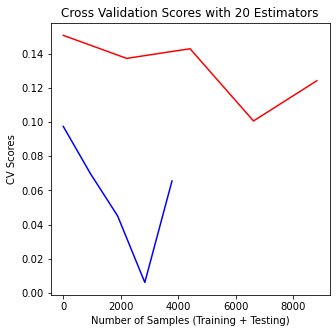

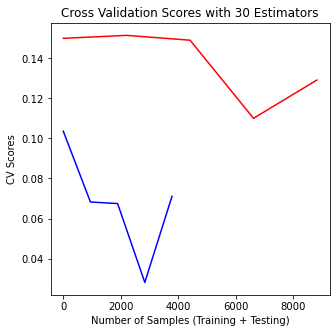

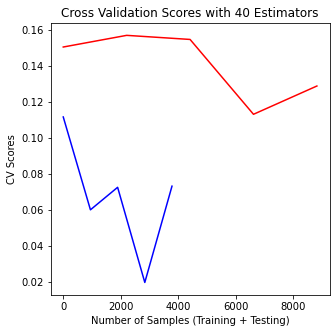

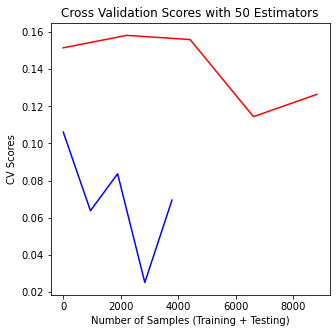

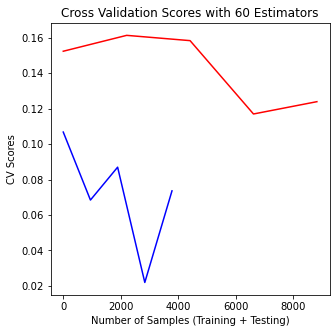

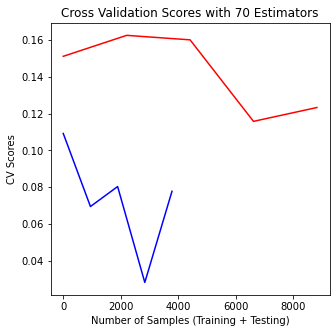

In [1025]:
'''Plotting the cross valiation scores for RandomForest classifer'''

print("RandomForest Classifier Learning Curves:\n ")

for i in range(len(testing_scores)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Cross Validation Scores with {estimators[i]} Estimators")
    plt.ylabel("CV Scores")
    plt.xlabel("Number of Samples (Training + Testing)")
    plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    plt.plot()

As seen above the features used ("hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide") aren't enough to predict the lengths of stay at the hospital so more features will be added to aid in teh classification process and accuracy will be re-measured. The minimum margin of error found is approximatley 23.7 when using Random Forests ehich ectremely high and inn acceptable. We can see from the graphs too how the difference between the predicted testing data and the predicted data is extremley high and reaching a difference upto 100 points which explains the high error margin. 

The cross validation scores for both the training and testign data also show how the model if failing to make predictions that is consistent with data given which further explains the high error margin.

# Introducing more features to predict the length of hospital stays:

Training Average CV Score:  0.6304138122062415
Testing Average CV Score:  0.5990461847098034
Training Error Margin with 20  Estimators:  4.946273354796703
Testing Error Margin with 20  Estimators:  9.729229313945865


Training Average CV Score:  0.6346978380765786
Testing Average CV Score:  0.6023635909995647
Training Error Margin with 30  Estimators:  4.925100710312844
Testing Error Margin with 30  Estimators:  9.78301824198213


Training Average CV Score:  0.6367453247276835
Testing Average CV Score:  0.60587770470931
Training Error Margin with 40  Estimators:  4.904341464515513
Testing Error Margin with 40  Estimators:  9.708093122990228


Training Average CV Score:  0.6377123877293001
Testing Average CV Score:  0.6083590303969835
Training Error Margin with 50  Estimators:  4.867651530853993
Testing Error Margin with 50  Estimators:  9.6821257979552


Training Average CV Score:  0.6389244813972313
Testing Average CV Score:  0.6092394621679222
Training Error Margin with 60  Estimator

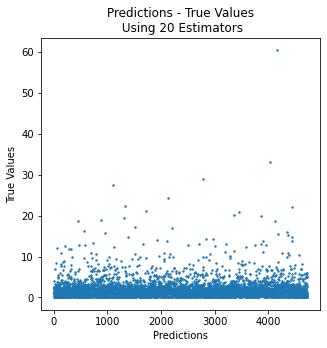

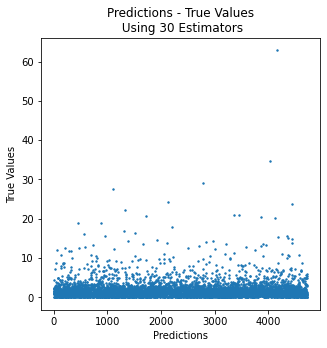

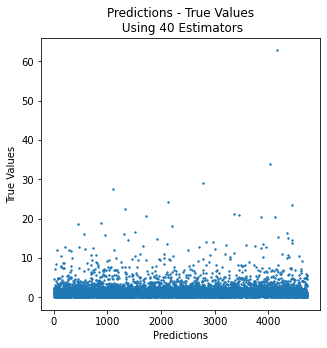

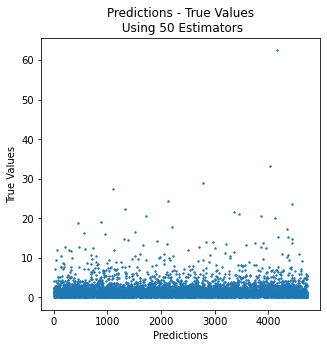

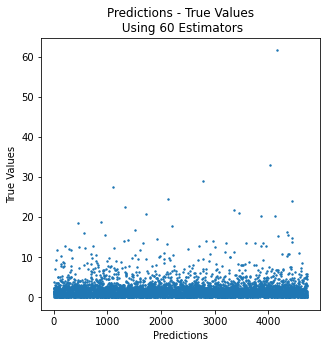

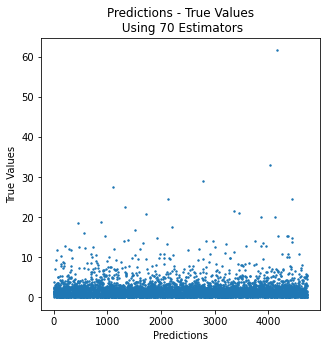

In [1026]:

'''We will be using RandomForests again as it is the best performing model based on the prior tests'''

label = "duration of stay"

features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
           "heart failure", "heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus"]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


estimators = [20, 30, 40 ,50 ,60, 70]
predictions = list()

training_scores = list()
testing_scores = list()

for estim in estimators:
    
    forest_classifier = RandomForestRegressor(n_estimators = estim,  max_depth = 10, n_jobs = -1, random_state = 1337)
    result = forest_classifier.fit(train_x, train_y)
    prediction_tr = result.predict(train_x).astype("float64")
    prediction_te = result.predict(test_x).astype("float64")
    predictions.append(prediction_te)
    
    training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
    testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)
    training_scores.append(training_cv_scores.copy())
    testing_scores.append(testing_cv_scores.copy())
    
    print("Training Average CV Score: ", np.average(training_cv_scores))
    print("Testing Average CV Score: ", np.average(testing_cv_scores))
    
    print(f"Training Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_tr, train_y))
    print(f"Testing Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")
    
for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {estimators[i]} Estimators")
    plt.xlabel("Predictions")
    plt.ylabel("True Values")
    plt.scatter(np.arange(0, len(predictions[i])) ,abs(predictions[i] - test_y), s = 2)

RandomForest Classifier Learning Curves:
 


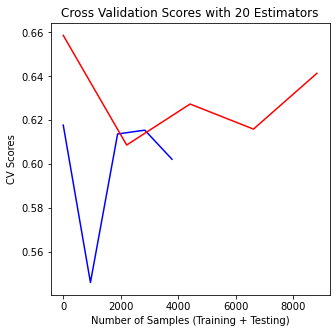

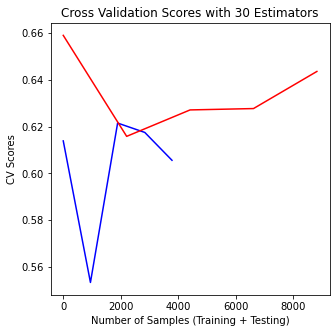

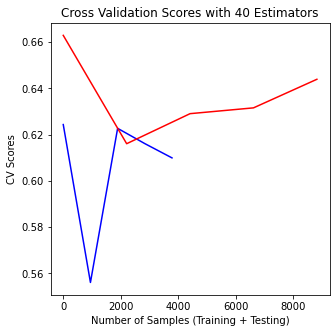

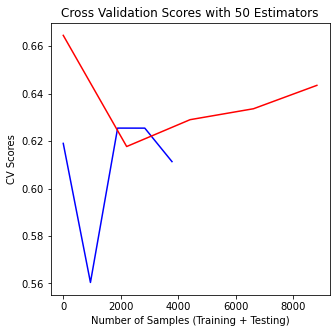

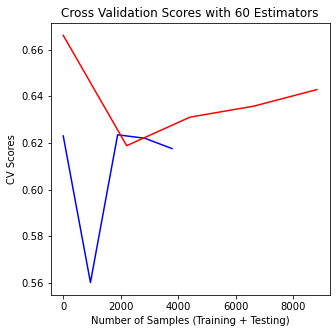

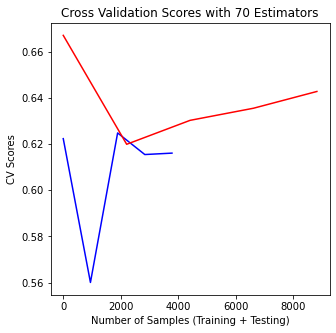

In [1027]:
'''Plotting the cross valiation scores for RandomForest classifer'''

print("RandomForest Classifier Learning Curves:\n ")

for i in range(len(testing_scores)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Cross Validation Scores with {estimators[i]} Estimators")
    plt.ylabel("CV Scores")
    plt.xlabel("Number of Samples (Training + Testing)")
    plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    plt.plot()

We can see after adding more features the error margin is down form about 23 to 9.7 with is a significant decrease; however, it is still a very high error value which means the data provided are messy and not providing enough insight for the model to predict accurately; in other words, there is a huge imbalance between the features values which creates a huge bias and overfitting that significanlty reduces the model precision when predicting the hospital duration of stay.

It is worth noting that with providing a great insight on how using more features/data can significanlty improve the accuacy of the model for both training and testing datasets espacially when comparing it to the prior Random Forest model with less data, we can see that the CV scores have improvded from minimally 0.04 to 0.56 and from 0.16 to 0.62 for testing and training data respectively.

Finally, it is worth noting that most added features contribute to below 1% decrease in error margin while when adding "duration of intensive unit stay" features th error margin droped from above 22 to below 10 which is indicating that it carries most of the information gain in predicting teh total stay at the hospital. Other features were added and tested manually from both the cleaned_features array and other remaining features like rural and date of admission which in best case scenario were able to boost the results by 0.01-0.02 for CV scores and error margins.

In [1028]:
'''Finally, We will try to find outliers in the duration of stay period (label) to minimize them and boost accuracy'''

print(f"Min {label} Period: ", np.min(data[label].values))
print(f"Max {label} Period: ", np.max(data[label].values))
print(f"Mean {label} Value: ", np.average(data[label].values))
print(f"Standard Deviation of {label} Value: ", np.std(data[label].values))

Min duration of stay Period:  1
Max duration of stay Period:  98
Mean duration of stay Value:  6.4150536269594465
Standard Deviation of duration of stay Value:  5.011261983775287


As we can see above, outliers exist as the average stay time is 6.4 days, and the max and min stays are 98 and 1 respectively which indicates a significant presence of outliers.

In [1029]:
'''Setting upper bounds to minimze outliers in the data'''

upper_bound = np.average(data[label].values) + (np.std(data[label].values) * 3)
data_temp = data.copy()

for i in range(len(data[label].values)):
    if data.loc[i, label] > upper_bound:
        data_temp.drop(i, axis = 0, inplace = True)


Training Average CV Score:  0.5982887811666167
Testing Average CV Score:  0.5746354587675114
Training Error Margin with 70  Estimators:  3.899917910283304
Testing Error Margin with 70  Estimators:  5.707616927047359




[]

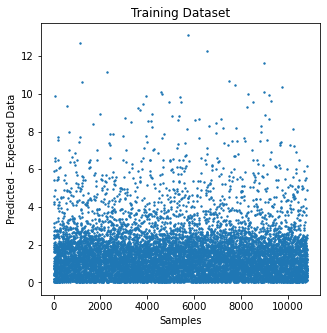

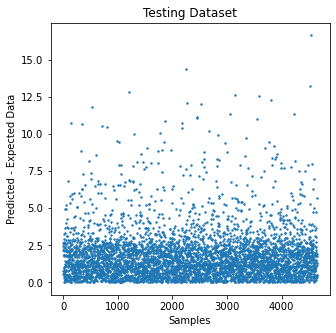

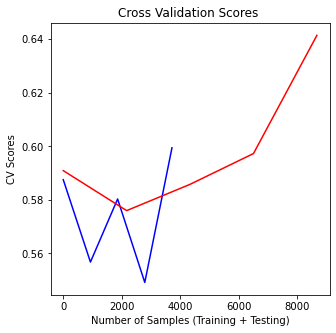

In [1030]:

'''We will be using RandomForests again as it is the best performing model based on the prior tests'''

label = "duration of stay"

features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
           "heart failure", "heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus", "gender"]

data_temp.loc[:,features[-1]] = LabelEncoder().fit_transform(data_temp[features[-1]])

train_x, test_x, train_y, test_y = train_test_split(data_temp[features].values, data_temp[label].values, test_size = 0.3,\
                                                    random_state = 1337)

    
forest_classifier = RandomForestRegressor(n_estimators = 70,  max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest_classifier.fit(train_x, train_y)
prediction_tr = result.predict(train_x).astype("float64")
prediction_te = result.predict(test_x).astype("float64")


training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)


print("Training Average CV Score: ", np.average(training_cv_scores))
print("Testing Average CV Score: ", np.average(testing_cv_scores))

print(f"Training Error Margin with 70  Estimators: ", mean_squared_error(prediction_tr, train_y))
print(f"Testing Error Margin with 70  Estimators: ", mean_squared_error(prediction_te, test_y))
print("\n")
    

    
plt.subplots(1, figsize = (5,5))
plt.title(f"Training Dataset")
plt.xlabel("Samples")
plt.ylabel("Predicted - Expected Data")
plt.scatter(np.arange(0, len(prediction_tr)) ,abs(prediction_tr - train_y), s = 2)


plt.subplots(1, figsize = (5,5))
plt.title(f"Testing Dataset")
plt.xlabel("Samples")
plt.ylabel("Predicted - Expected Data")
plt.scatter(np.arange(0, len(prediction_te)) ,abs(prediction_te - test_y), s = 2)


plt.subplots(1, figsize = (5,5))
plt.title(f"Cross Validation Scores ")
plt.ylabel("CV Scores")
plt.xlabel("Number of Samples (Training + Testing)")
plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_cv_scores)) , testing_cv_scores, color = "blue")
plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_cv_scores)) , training_cv_scores, color = "red")
plt.plot()

After minimizing the outlier we can see that the error margin for testing data is reduced by almost 50% and for training data is reduced by almost 20%; however, both values are still very large to trust the model and its predictions.

The CV scores are reduced by about 0.04 for the training data and by about 0.01 for the testing data which indicates overfitting is occuring more due to less data being used for the model to train by.

In [1031]:
'''Removing outliers from blood tests features while other features and the label remain the same'''

names = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "age",\
         "duration of intensive unit stay"]

data_temp = data.copy()

indexes = list()

for i in range(len(names)):
    
    mean = np.mean(data_temp[names[i]].values)
    stdev = np.std(data_temp[names[i]].values)
    
    for j in range(len(data_temp[names[i]].values)):
        
        '''Upper bound'''
        if data_temp.loc[j, names[i]] > (mean + (stdev * 3)):

            indexes.append(j)
            
        '''Lower bound'''
        if data_temp.loc[j, names[i]] < (mean - (stdev * 3)):
            
            indexes.append(j)
            

'''Dropping outliers'''            
data_temp.drop(data_temp.index[indexes], inplace = True)

Training Average CV Score:  0.5027946526883961
Testing Average CV Score:  0.4824601291697316
Training Error Margin with 70  Estimators:  4.175954869658964
Testing Error Margin with 70  Estimators:  7.6271763444514304




[]

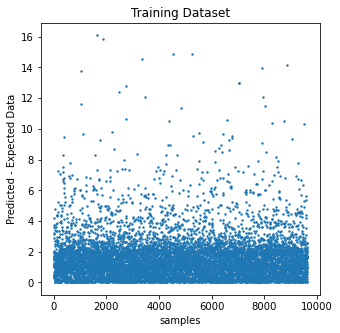

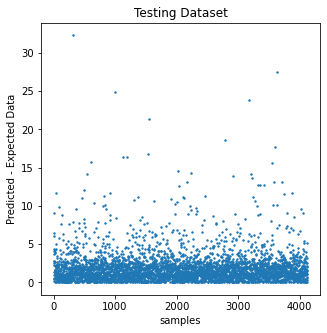

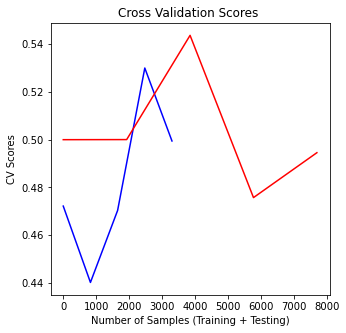

In [1032]:

'''We will be using RandomForests again as it is the best performing model based on the prior tests'''

label = "duration of stay"

features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
           "heart failure", "heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus", "gender"]

data_temp.loc[:,features[-1]] = LabelEncoder().fit_transform(data_temp[features[-1]])

train_x, test_x, train_y, test_y = train_test_split(data_temp[features].values, data_temp[label].values, test_size = 0.3,\
                                                    random_state = 1337)

    
forest_classifier = RandomForestRegressor(n_estimators = 70,  max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest_classifier.fit(train_x, train_y)
prediction_tr = result.predict(train_x).astype("float64")
prediction_te = result.predict(test_x).astype("float64")


training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)


print("Training Average CV Score: ", np.average(training_cv_scores))
print("Testing Average CV Score: ", np.average(testing_cv_scores))

print(f"Training Error Margin with 70  Estimators: ", mean_squared_error(prediction_tr, train_y))
print(f"Testing Error Margin with 70  Estimators: ", mean_squared_error(prediction_te, test_y))
print("\n")
    

    
plt.subplots(1, figsize = (5,5))
plt.title(f"Training Dataset")
plt.xlabel("samples")
plt.ylabel("Predicted - Expected Data")
plt.scatter(np.arange(0, len(prediction_tr)) ,abs(prediction_tr - train_y), s = 2)


plt.subplots(1, figsize = (5,5))
plt.title(f"Testing Dataset")
plt.xlabel("samples")
plt.ylabel("Predicted - Expected Data")
plt.scatter(np.arange(0, len(prediction_te)) ,abs(prediction_te - test_y), s = 2)


plt.subplots(1, figsize = (5,5))
plt.title(f"Cross Validation Scores ")
plt.ylabel("CV Scores")
plt.xlabel("Number of Samples (Training + Testing)")
plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_cv_scores)) , testing_cv_scores, color = "blue")
plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_cv_scores)) , training_cv_scores, color = "red")
plt.plot()

We can finally conclude that even when removing the outliers from the data we can see only little reduction in both the training and testing datsets error margins and CV score tend to go lower as less data is provided which indicates further overfitting.

The most signifcant reduction in error margin is seen only when removing outliers from the label vector but CV scores tend to remain the approximatley the same.

It is worth noting without removing the outliers from the "duration of intensive unit stay" feature data, the CV score for the testing can reach a max value 0.7 while the training data is inceased to about 0.65; however, the error margin tend to increase to more than 9 for the testing dataset and almost reaching about 4.7 for training datset.

It is clear that more features outside the dataste are needed to perfectly predict the patients duration of stay and no optimization or model will likely be able to reduce the error margins by more than 90% to be anywhere effecient and trustable.

It is also worth noting that by manual check-up the duration of intensive unit stay for patients seems to have the most effect on predicting the total period of hospital stay, followed by the age of the patient which had a less effect on the predictibility of the algorithim. Other features almost equally provided only a boost of usually about 0.0001 - 0.001 to CV scores which is very minimal; furthermore, a similar decrease in error margins was also noted.

## We will be predicting the accuracy of given data in detremining if a patient has a heart failure or not:

Training Average CV Score with 20  Estimators:  0.09008013925021414
Testing Average CV Score with 20  Estimators:  0.06838274201753555
Training Error Margin with 20  Estimators:  0.15957455215512167
Testing Error Margin with 20  Estimators:  0.18747232078072984


Training Average CV Score with 30  Estimators:  0.09317073744469417
Testing Average CV Score with 30  Estimators:  0.07256251679572578
Training Error Margin with 30  Estimators:  0.15938447946586418
Testing Error Margin with 30  Estimators:  0.1873322562521402


Training Average CV Score with 40  Estimators:  0.09493033734859031
Testing Average CV Score with 40  Estimators:  0.07494703999414487
Training Error Margin with 40  Estimators:  0.15923524023415356
Testing Error Margin with 40  Estimators:  0.18721847494715868


Training Average CV Score with 50  Estimators:  0.09597607347403422
Testing Average CV Score with 50  Estimators:  0.0780881163467914
Training Error Margin with 50  Estimators:  0.15923610279968078
Testing Err

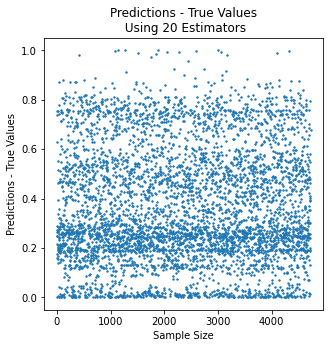

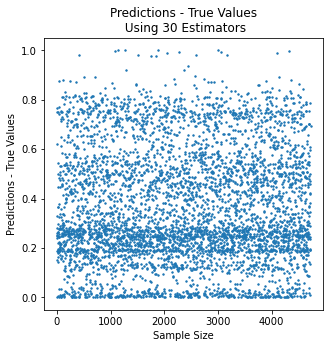

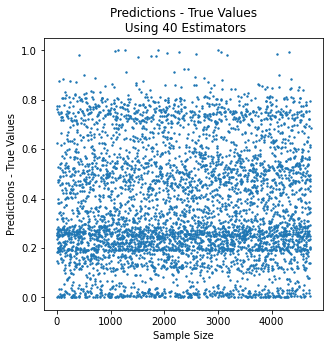

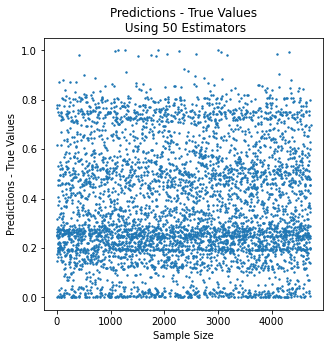

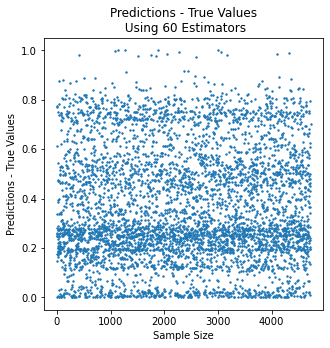

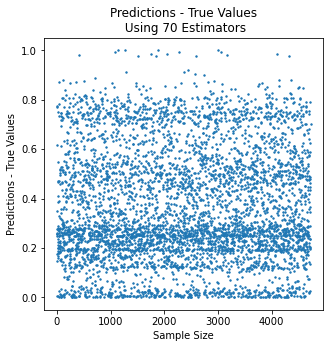

In [1033]:

label = "heart failure"

features = ["stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",\
            "coronary artery disease", "raised cardiac enzymes", "age", "gender"]

data[features[-1]] = LabelEncoder().fit_transform(data[features[-1]])


"""We will start by using the Random Forest modle as it is teh best performing model from prior tests"""

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


estimators = [20, 30, 40 ,50 ,60, 70]
predictions = list()

training_scores = list()
testing_scores = list()

for estim in estimators:
    
    forest_classifier = RandomForestRegressor(n_estimators = estim,  max_depth = 10, n_jobs = -1, random_state = 1337)
    result = forest_classifier.fit(train_x, train_y)
    prediction_tr = result.predict(train_x).astype("float64")
    prediction_te = result.predict(test_x).astype("float64")
    predictions.append(prediction_te)
    
    training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
    testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)
    training_scores.append(training_cv_scores.copy())
    testing_scores.append(testing_cv_scores.copy())
    
    print(f"Training Average CV Score with {estim}  Estimators: ", np.average(training_cv_scores))
    print(f"Testing Average CV Score with {estim}  Estimators: ", np.average(testing_cv_scores))
    
    print(f"Training Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_tr, train_y))
    print(f"Testing Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")
    
for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {estimators[i]} Estimators")
    plt.xlabel("Sample Size")
    plt.ylabel("Predictions - True Values")
    plt.scatter(np.arange(0, len(predictions[i])) , abs(predictions[i] - test_y), s = 2)

RandomForest Classifier Learning Curves:
 


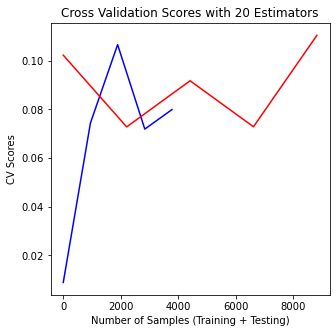

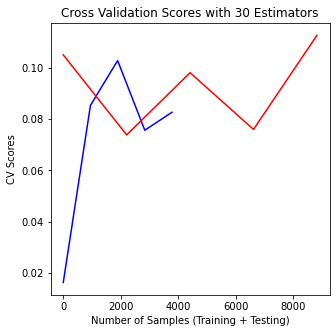

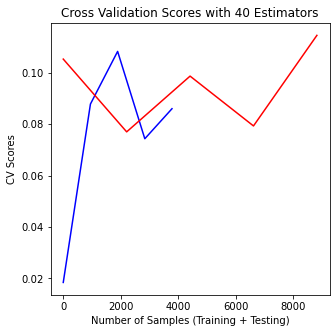

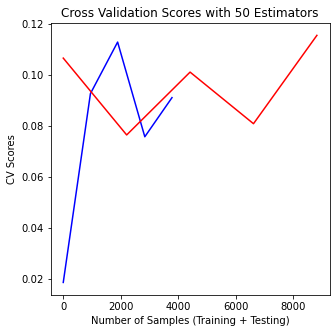

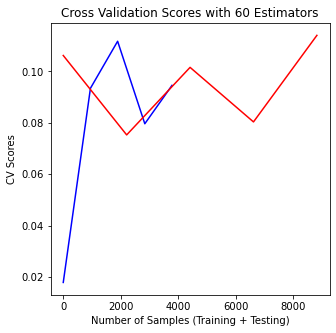

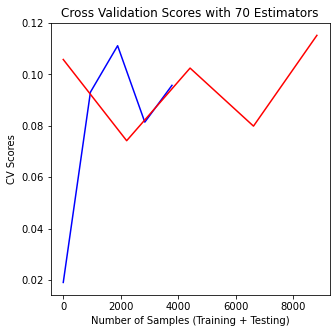

In [1034]:
'''Plotting the cross valiation scores for RandomForest classifer'''

print("RandomForest Classifier Learning Curves:\n ")

for i in range(len(testing_scores)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Cross Validation Scores with {estimators[i]} Estimators")
    plt.ylabel("CV Scores")
    plt.xlabel("Number of Samples (Training + Testing)")
    plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    plt.plot()

Training Average CV Score with 20  Estimators:  0.36896161283514983
Testing Average CV Score with 20  Estimators:  0.3615639259779696
Training Error Margin with 20  Estimators:  0.08707297678011962
Testing Error Margin with 20  Estimators:  0.12781030470017304


Training Average CV Score with 30  Estimators:  0.37301301278010107
Testing Average CV Score with 30  Estimators:  0.3690717313197008
Training Error Margin with 30  Estimators:  0.08653337108546524
Testing Error Margin with 30  Estimators:  0.12731574400498344


Training Average CV Score with 40  Estimators:  0.3736541391761053
Testing Average CV Score with 40  Estimators:  0.3714250723401638
Training Error Margin with 40  Estimators:  0.08631605395795523
Testing Error Margin with 40  Estimators:  0.127177292891412


Training Average CV Score with 50  Estimators:  0.37520181133037134
Testing Average CV Score with 50  Estimators:  0.37204927285403677
Training Error Margin with 50  Estimators:  0.08588301065564483
Testing Error M

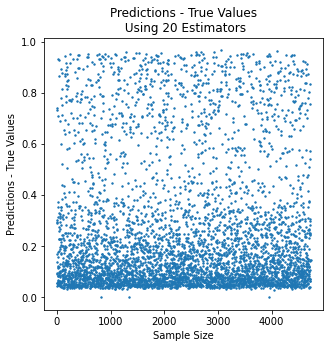

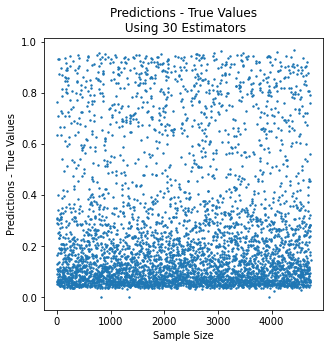

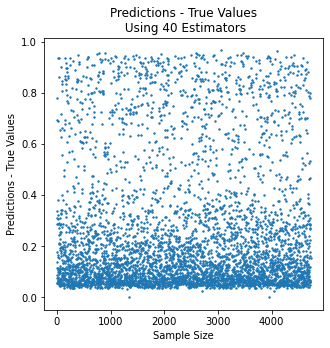

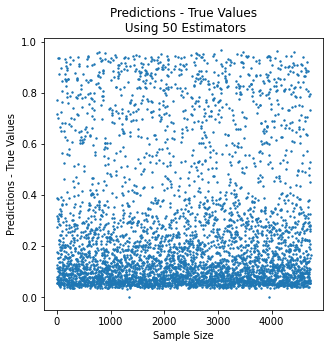

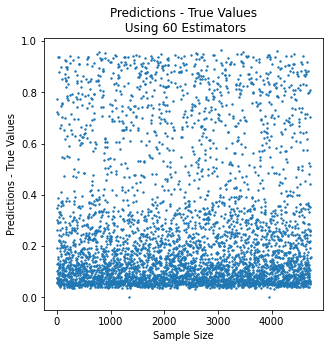

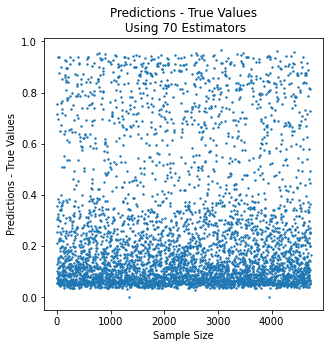

In [1035]:
'''We will add blood tests results with the activities, gender and age to check'''

label = "heart failure"

features = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
            "stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",\
            "coronary artery disease", "raised cardiac enzymes", "age", "gender"]

data[features[-1]] = LabelEncoder().fit_transform(data[features[-1]])


"""We will start by using the Random Forest modle as it is the best performing model from prior tests"""

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


estimators = [20, 30, 40 ,50 ,60, 70]
predictions = list()

training_scores = list()
testing_scores = list()

for estim in estimators:
    
    forest_classifier = RandomForestRegressor(n_estimators = estim,  max_depth = 10, n_jobs = -1, random_state = 1337)
    result = forest_classifier.fit(train_x, train_y)
    prediction_tr = result.predict(train_x).astype("float64")
    prediction_te = result.predict(test_x).astype("float64")
    predictions.append(prediction_te)
    
    training_cv_scores = cross_val_score(forest_classifier, train_x, train_y, cv = 5)
    testing_cv_scores = cross_val_score(forest_classifier, test_x, test_y, cv = 5)
    training_scores.append(training_cv_scores.copy())
    testing_scores.append(testing_cv_scores.copy())
    
    print(f"Training Average CV Score with {estim}  Estimators: ", np.average(training_cv_scores))
    print(f"Testing Average CV Score with {estim}  Estimators: ", np.average(testing_cv_scores))
    
    print(f"Training Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_tr, train_y))
    print(f"Testing Error Margin with {estim}  Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")
    
for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Predictions - True Values\n Using {estimators[i]} Estimators")
    plt.xlabel("Sample Size")
    plt.ylabel("Predictions - True Values")
    plt.scatter(np.arange(0, len(predictions[i])) , abs(predictions[i] - test_y), s = 2)

RandomForest Classifier Learning Curves:
 


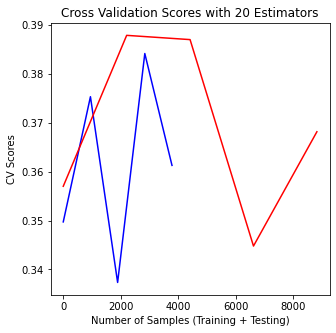

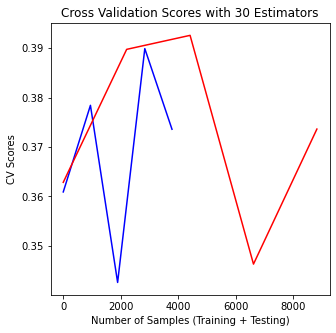

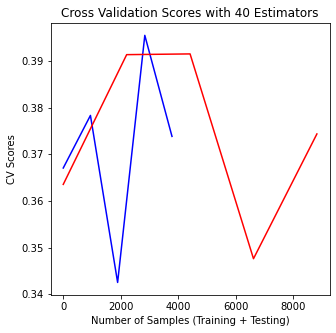

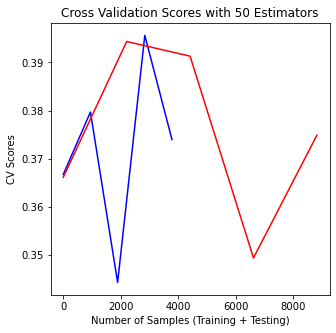

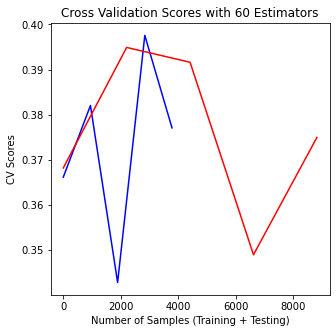

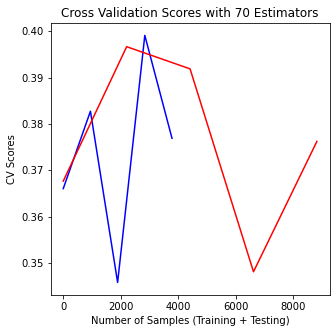

In [1036]:
'''Plotting the cross valiation scores for RandomForest classifer'''

print("RandomForest Classifier Learning Curves:\n ")

for i in range(len(testing_scores)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Cross Validation Scores with {estimators[i]} Estimators")
    plt.ylabel("CV Scores")
    plt.xlabel("Number of Samples (Training + Testing)")
    plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    plt.plot()

Training Average CV Score with 70  Estimators:  0.7737780080300479
Testing Average CV Score with 70  Estimators:  0.8318549839480072
Train Error Margin:  0.0020854111886843777
Test Error Margin:  0.2068527918781726


[]

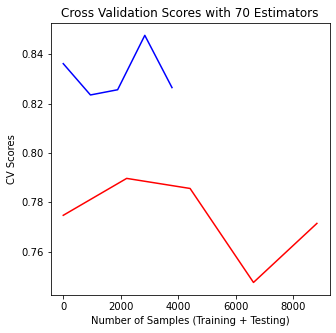

In [19]:
'''Using AdaBoostClassifier to further boost the CV scores and reduce error margin'''
'''70 estimaors will be used as it is the best hyperparameter chekced while using Random Forests'''


ada_classifier = AdaBoostClassifier(base_estimator = RandomForestClassifier(), n_estimators = 70, random_state = 1337)
result = ada_classifier.fit(train_x, train_y)
prediction_tr = result.predict(train_x)
prediction_te = result.predict(test_x)

training_cv_scores = cross_val_score(ada_classifier, train_x, train_y,  n_jobs = -1, cv = 5)
testing_cv_scores = cross_val_score(ada_classifier, test_x, test_y, n_jobs = -1, cv = 5)

print(f"Training Average CV Score with {estim}  Estimators: ", np.average(training_cv_scores))
print(f"Testing Average CV Score with {estim}  Estimators: ", np.average(testing_cv_scores))

print("Train Error Margin: " ,mean_squared_error(prediction_tr, train_y))
print("Test Error Margin: ", mean_squared_error(prediction_te, test_y))

plt.subplots(1, figsize = (5,5))
plt.title(f"Cross Validation Scores with {estimators[i]} Estimators")
plt.ylabel("CV Scores")
plt.xlabel("Number of Samples (Training + Testing)")
plt.plot(np.arange(0, len(test_x), len(test_x)/len(training_cv_scores)) , testing_cv_scores, color = "blue")
plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_cv_scores)) , training_cv_scores, color = "red")
plt.plot()

As CV scores have been improved significantly (more than 2 times) between RandomForests and AdaBoost this means there is a good chance to further mprove the results using an neural netweorks ensemble model that more effecient in handling weak learners through the significant number of weights generated and tested compared to AdaBoost.

# Using neural netwroks to predict heart failure:

Best Paramater:  {'batch_size': 100, 'epochs': 70}
Best Score:  0.8119505451016915

Training Error Margin:  0.14489074258772328
Training Accuracy:  0.8551092574122767

Testing Error Margin:  0.1823181049069374
Testing Accuracy:  0.8176818950930627


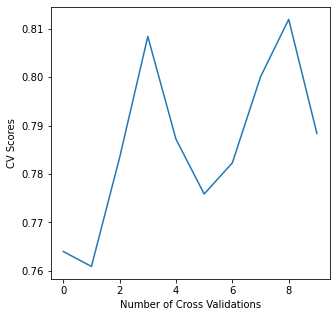

In [194]:
data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network():
    layers = tf.keras.Sequential()

    layers.add(tensor_normalizer)
    layers.add(Dense(100, activation = "relu"))
    layers.add(Dense(100, activation = "relu"))
    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "accuracy" )
    
    return layers

tf_classifier = KerasClassifier(model = run_network, verbose = 0)

param_testing = {"epochs" : [10, 30, 50, 70, 100], "batch_size" : [70, 100]}
grid_search = GridSearchCV(estimator = tf_classifier, param_grid = param_testing, cv = 5, verbose = 0)
fitting = grid_search.fit(train_x, train_y)




print("Best Paramater: ", fitting.best_params_)
print("Best Score: ", fitting.best_score_)
print()

prediction = grid_search.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)

print()
prediction = grid_search.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize=(5,5))
plt.ylabel("CV Scores")
plt.xlabel("Number of Cross Validations")
plt.plot(np.arange(0, len(fitting.cv_results_["mean_test_score"])), fitting.cv_results_["mean_test_score"] )

#References:
#https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

As a simple neural network is used above it with only dense layers the accuracy is quite high and almost on par with AdaBoost model for both training and testing datasets.

With trial and error it seems 100 nodes in the hidden layer is near the threshold before the model starts overfitting and accuracy drops significantly.

As seen with grid search it seems that the best hyperparameters for the neural network model is with epochs = 70 and batch size = 100 in which these values will be used in the upcoming more complex models for simplicity and avoid time consuming grid search process.

# We will modifiy neural netwrok model with dropout rates and regularization parameters:

Best Paramater:  {'model__dropout_rate': 0.1, 'model__reg_val': 1e-05}
Best Score:  0.8141263057051168

Training Error Margin:  0.15966996101187778
Training Accuracy:  0.8403300389881222

Testing Error Margin:  0.17280033840947548
Testing Accuracy:  0.8271996615905245


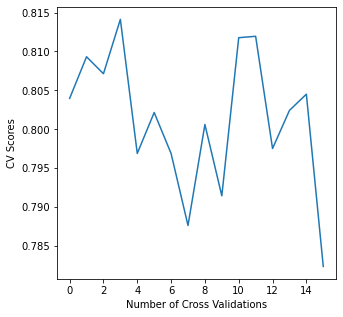

In [195]:
data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network(dropout_rate = 0, reg_val = 0):
    layers = tf.keras.Sequential()

    layers.add(tensor_normalizer)
    
    layers.add(Dense(100, activation = "relu",\
               activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))
    
    
    layers.add(Dense(100, activation = "relu",\
                    activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))
    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "accuracy" )
    
    return layers

tf_classifier = KerasClassifier(model = run_network, epochs = 70, batch_size = 100, verbose = 0)

param_testing = {"model__dropout_rate" : [1e-1, 1e-3, 1e-5, 1e-7], "model__reg_val" : [1, 1e-1, 1e-3, 1e-5]}
grid_search = GridSearchCV(estimator = tf_classifier, param_grid = param_testing, cv = 5, verbose = 0)
fitting = grid_search.fit(train_x, train_y)


print("Best Paramater: ", fitting.best_params_)
print("Best Score: ", fitting.best_score_)
print()

prediction = grid_search.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)

print()
prediction = grid_search.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize=(5,5))
plt.ylabel("CV Scores")
plt.xlabel("Number of Cross Validations")
plt.plot(np.arange(0, len(fitting.cv_results_["mean_test_score"])), fitting.cv_results_["mean_test_score"] )

By adding a regularization and dropout parameters the training and testing accuracy have increased by approximatley 2% compared to the previous neural network model and AdaBoost classifier.

After conducting the gird search to find the best possible values for the dropout and the regulariation parameters from the range of given values, we can safely set dropout = 0.1 and regularization = 1e-5 for upcoming neural netwrok models while also having the epochs = 70 and batch size = 100 as discussed in the previous model.

# We will add 3 more dense layers and check if further accuracy improvements will be captured:

In [196]:
data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)


layers = tf.keras.Sequential()
layers.add(tensor_normalizer)
    
layers.add(Dense(100, activation = "relu",\
           activity_regularizer = regularizer.L2(1e-5)))
layers.add(Dropout(0.1))
        
layers.add(Dense(100, activation = "relu",\
                    activity_regularizer = regularizer.L2(1e-5)))
layers.add(Dropout(0.1))

layers.add(Dense(100, activation = "relu",\
                    activity_regularizer = regularizer.L2(1e-5)))
layers.add(Dropout(0.1))

layers.add(Dense(100, activation = "relu",\
                    activity_regularizer = regularizer.L2(1e-5)))
layers.add(Dropout(0.1))

layers.add(Dense(100, activation = "relu",\
                    activity_regularizer = regularizer.L2(1e-5)))
layers.add(Dropout(0.1))

layers.add(Dense(1))

layers.compile(optimizer = "adam", loss = "binary_crossentropy")
layers.fit(train_x, train_y, epochs = 70, batch_size = 100, verbose = 0)



prediction = layers.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = layers.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))

345/345 [==============================] - 0s 694us/step
Training Error Margin:  0.10590119195112607
Training Accuracy:  0.8940988080488739

148/148 [==============================] - 0s 634us/step
Testing Error Margin:  0.1443676011709023
Testing Accuracy:  0.8556323988290977


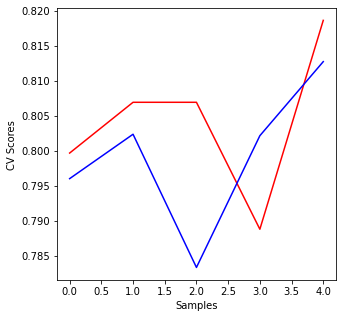

In [876]:
'''Calculating cross validation scores for training and testing datasets'''

data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network():
    
    layers = tf.keras.Sequential()
    layers.add(tensor_normalizer)

    layers.add(Dense(100, activation = "relu",\
               activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy")
    layers.fit(train_x, train_y, epochs = 70, batch_size = 100, verbose = 0)
    
    return layers


tf_classifier = KerasClassifier(model = run_network , epochs = 70, batch_size = 100, verbose = 0)
scores_tr = cross_val_score(tf_classifier, train_x, train_y, cv = 5)
scores_te = cross_val_score(tf_classifier, test_x, test_y, cv = 5)


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(scores_te)), scores_te, color = "blue")

By using neural netwroks we can see that the CV scores for the training data is slightlty better with 0.03 increase and for the testing data, the CV score is slightly reduced by 0.01. The error margin for the training dataste is increased for the training dataset bu 0.004 and decreased for the testing dataset by about 0.1.

Both Adaboost and neural netwroks performed really well here with slight variations in output accuracy and while one model performs better on CV scores and other gives less error margin, and overall both models are performing at almost the same level.

It is worth noting that by manual check-up, heart failure prediction is mostly affected by brain natriuretic peptide feature which represent the substances made by the heart and can be used to indicate heart failure in medicine; furthermore, pulmonary embolism feature also played a lower role in predicting heart failure as it represents blood clots in the lung that stop oxygen from reaching it. Other features effects were minimal on CV scores but still provided a boost of 0.0001 to error margin individually. 

# We will try to predict the glucose levels of patients and its linke to heart failure, smoking, aneamia and other conditions the patients could be suffering from.

# We will start with Random Forest classifer:

Training Score:  0.011257071707924449
Training Error Margin:  0.0099379622115363
Training Accuracy:  0.9900620377884637

Testing Score:  -0.0208465982938137
Testing Error Margin:  0.010168676323010143
Testing Accuracy:  0.9898313236769899


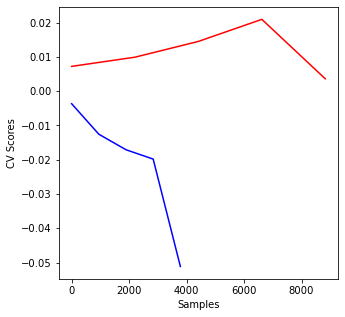

In [1038]:
''''We will start by choosing features that represent few of of the current diseases the pateint could be suffering from'''

label = "glucose"
features = ["heart failure", "smoking ", "alcohol", "severe anaemia", "anaemia", "chronic kidney disease",
            "atypical chest pain", "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease"]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

#We will stick to 70 estimators to avoid timely cross validations.

forest = RandomForestRegressor(n_estimators = 70, max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest.fit(train_x, train_y)
prediction = forest.predict(train_x)

error = mean_squared_error(prediction, train_y)
scores_tr = cross_val_score(forest, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()

prediction = forest.predict(test_x)
scores_te = cross_val_score(forest, test_x, test_y, cv = 5)


print("Testing Score: ", np.average(scores_te))
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

Depite the high accuracy result, the cross validations score is very low possibly due to the severe imbalance between the classes number in the label vector (glucose levels) which is geneating significant overfitting and lots of false positives and negatives that give a false belief that the model is precise.

# More features will be added to check if accuracy can be boosted 

Training Score:  0.14619669297841656
Training Error Margin:  0.006595094177980604
Training Accuracy:  0.9934049058220193

Testing Score:  0.10684079664451643
Testing Error Margin:  0.008617171312327624
Testing Accuracy:  0.9913828286876724


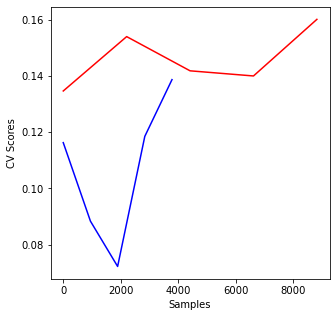

In [9]:
''''We will add age, gender and other diseases the pateinet could suffering from'''

label = "glucose"
features = ["heart failure", "stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",\
            "coronary artery disease", "raised cardiac enzymes", "age", "gender"]


data.loc[:,features[-1]] = LabelEncoder().fit_transform(data[features[-1]])


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

#We will stick to 70 estimators to avoid timely cross validations.

forest = RandomForestRegressor(n_estimators = 70, max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest.fit(train_x, train_y)
prediction = forest.predict(train_x)

error = mean_squared_error(prediction, train_y)
scores_tr = cross_val_score(forest, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()

prediction = forest.predict(test_x)
scores_te = cross_val_score(forest, test_x, test_y, cv = 5)


print("Testing Score: ", np.average(scores_te))
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

We can see even when adding most of the provided diseases the patient could be suffering from, the cross validation scores are slightly boosted compared to the previous model and overfitting and missclassifications are still occuring heavily.

It is worth noting that AdaBoost will not be used here as the predicited value is numerical and not categorical which will require intensive re-formation of the data based to classify the patient to either diabetic or not based on glucose levels, and unfortunatley no ranges are provided by teh publisher of the dataset.

Neural networks will not be used either as when cross validating after each layer, the data have only 1 class due to the imbalnce in the dataset which renders the model useless as teh effeceincy against RandomForests can't be fully tested.

In [ ]:
'''Using Linear SVR'''
svr_classifier = svm.SVR(C = 1, kernel = "linear", gamma = "scale")

params = {"C" : [1e4, 1e2, 10, 1, 1e-1, 1e-2, 1e-4]}

grid_search_cv = GridSearchCV(svr_classifier, param_grid = params, n_jobs = -1, cv = 5)
result = grid_search_cv.fit(train_x,train_y)
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)

In [26]:
print("Best Parameter:", grid_search_cv.best_params_)
print("Best Parameter Score: ", grid_search_cv.best_score_)
print("Best Parameter Error Margin: ", error)

Best Parameter: {'C': 100.0}
Best Parameter Score:  0.19493346859995825
Best Parameter Error Margin:  0.1615822776874487


Best Parameter: {'degree': 2}
Best Parameter Score:  0.14871706674402704

Best Parameter Training Error Margin:  0.1740596430965534

Best Parameter Testing Error Margin:  0.17741445851080082


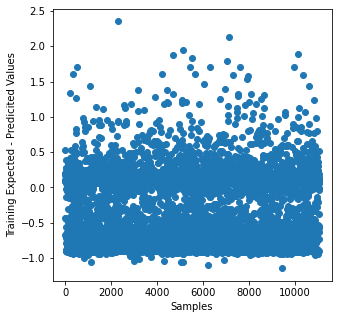

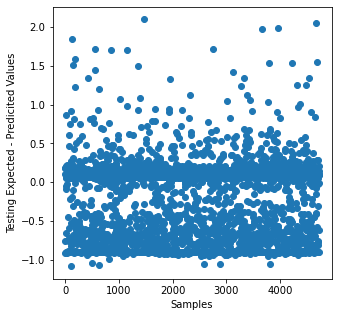

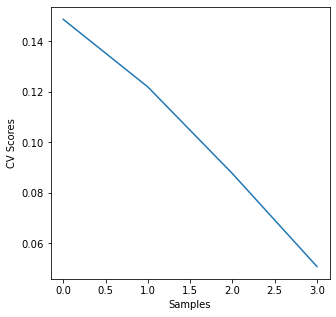

In [46]:
'''Using Polynomial SVR'''

svr_classifier = svm.SVR(C = 1e2, kernel = "poly", degree = 2, gamma = "scale")

params = {"degree" : [2, 3, 4, 5]}

grid_search_cv = GridSearchCV(svr_classifier, param_grid = params, n_jobs = -1, cv = 5)
result = grid_search_cv.fit(train_x,train_y)
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)

print("Best Parameter:", grid_search_cv.best_params_)
print("Best Parameter Score: ", grid_search_cv.best_score_)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


print("Best Parameter Training Error Margin: ", error)
print()

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Best Parameter Testing Error Margin: ", error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))

plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])


Testing Score:  -24682798.082306564
Testing Error Margin:  42622447.92724958


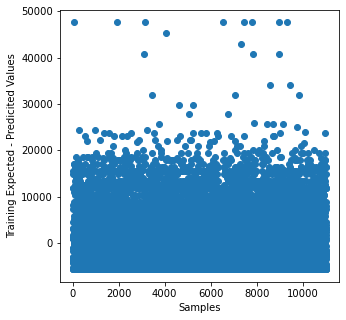

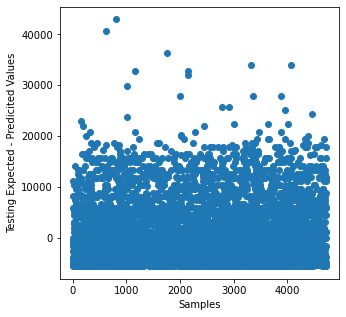

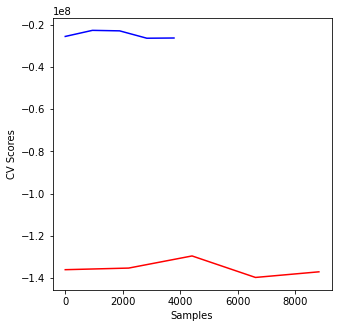

In [45]:
'''Using Sigmoid SVR'''

svr_classifier = svm.SVR(C = 1e2, kernel = "sigmoid", gamma = "scale")


result = svr_classifier.fit(train_x,train_y)
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)

scores_tr = cross_val_score(svr_classifier, train_x, train_y, cv = 5)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))



prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
scores_te = cross_val_score(svr_classifier, test_x, test_y, cv = 5)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


print("Testing Score: ", np.average(scores_te))
print("Testing Error Margin: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

Training Score:  0.12154694003836386
Training Error Margin:  0.008954406180629731

Testing Score:  0.10861143649813518
Testing Error Margin:  0.00887168049743618


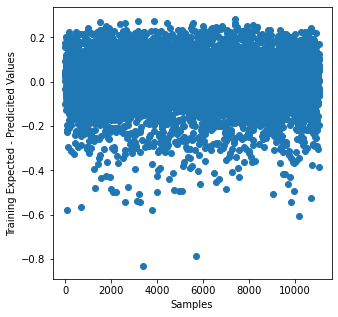

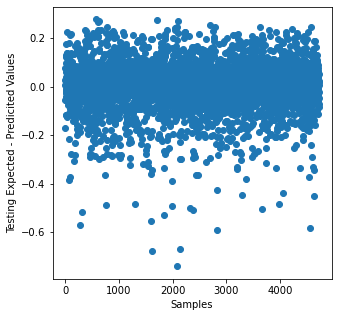

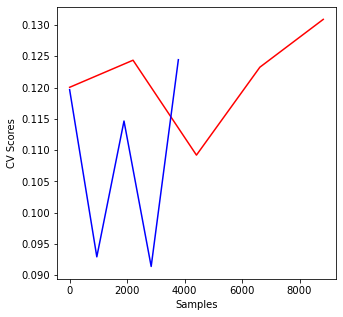

In [64]:
'''Using RBF SVR'''

svr_classifier = svm.SVR(C = 1e2, kernel = "rbf", gamma = "scale")


result = svr_classifier.fit(train_x,train_y)
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)

scores_tr = cross_val_score(svr_classifier, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
scores_te = cross_val_score(svr_classifier, test_x, test_y, cv = 5)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


print("Testing Score: ", np.average(scores_te))
print("Testing Error Margin: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

Best Params:  {'alpha': 0.001, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5}
Best Score:  0.15253431348712906

Training Error:  0.008237054241449014

Testing Error:  0.008613875006899805


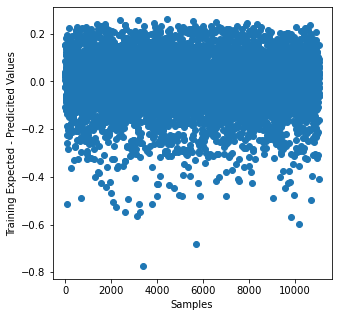

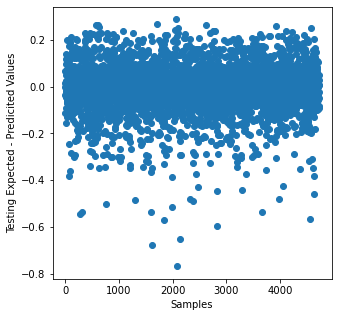

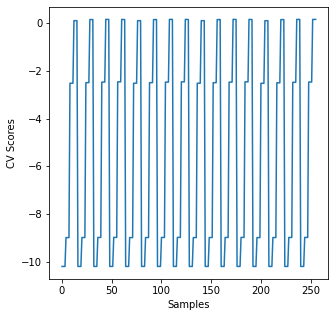

In [8]:
'''Using XGBoost'''


xgb_classifier = xgb.XGBRegressor(objective = "reg:logistic", colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 1, n_estimators = 70)


params = {"colsample_bytree" : [0.1, 0.3, 0.5, 0.7], "learning_rate" : [0.0001, 0.001, 0.01, 0.1], "max_depth" : [3, 5, 7, 10],
         "alpha" : [1e-5, 1e-3, 1e-1, 1]}

grid_search_cv = GridSearchCV(xgb_classifier, param_grid = params, n_jobs = -1, cv = 5)


result = grid_search_cv.fit(train_x, train_y)
print("Best Params: ", grid_search_cv.best_params_)
print("Best Score: ", grid_search_cv.best_score_ )
print()


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])


#References:
#https://www.datacamp.com/tutorial/xgboost-in-python

After trying with the moels above we can definitly confirn that the model is severly overfitting despite the signifcant addition of data/features. Through the figures of each model we can see the variations between the predicted and the expected data mostly lying above or below zero for most points which further explains the overfitting; furthermore, the cross validation scores remains very low.

It is worth noting that despite overfitting, XGBoost is achieving the best results compared to all tested models and with the lowest error margin recorded yet despite the highe CV score when using Linear SVR model which indicates higher accurate results.

We can conclude that the curent diseases, conditions, habits, gender and age od the patients aren't enough to predict their glucose levels effecienlty.

# We will introduce blood tests to the curent selected features and check if any accuracy scores change at all. We will use XGBoost as it is our best performing model so far.

Training Score:  0.19448246347542503
Training Error:  0.004340596417044424

Testing Score:  0.14679729478489162
Testing Error:  0.008035166400831083


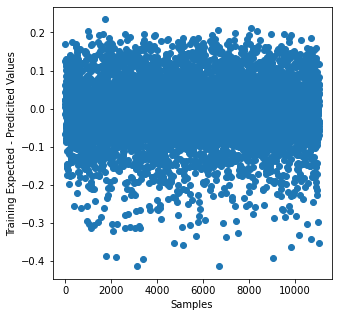

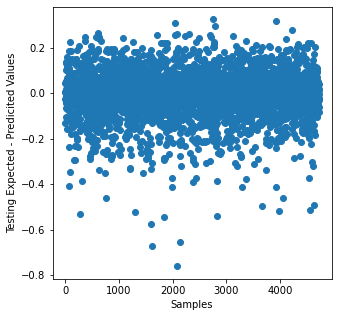

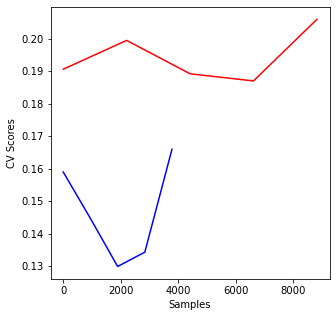

In [1041]:
label = "glucose"
features = ["heart failure", "stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",
            "coronary artery disease", "raised cardiac enzymes", "age", "gender", "hb", "leucocyte count", "platelets", "urea", 
            "creatinine", "brain natriuretic peptide"]



train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


'''We will use the best parameters selected from the grid search in the previous XGBoost model.'''

xgb_classifier = xgb.XGBRegressor(objective = "reg:logistic", colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 10, alpha = 0.001, n_estimators = 70)



result = xgb_classifier.fit(train_x, train_y)

scores_tr = cross_val_score(xgb_classifier, train_x, train_y, cv = 5)
print("Training Score: ", np.average(scores_tr))


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

scores_te = cross_val_score(xgb_classifier, test_x, test_y, cv = 5)
print("Testing Score: ", np.average(scores_te))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

We can see even when adding the blood tests of patients, the cross validation score is still very low despite the reduction in the error margin for both training and testing datasets.

It is safe to conclude that is ineffecient to use the provided blood tests and current diseases the pateint is having to predict their glucose levels and as all tested models show overfitting depite various hyperparameters, we can't effeciently predict glucose levels of patient on the given dataset with optimal precision compared to the expected data.

It is worth noting that by manual check-up diabetes mellitus which represents ability of the body in harnessing glucose levels seems to provide the most information gain among the rest of the features with about 0.1 increase on CV scores and a very minimal reduction in error margin that is about 0.0001 when combined with other given features.

Providing the age, gender, hb, leucocyte count, platelets, urea, creatinine, brain natriuretic peptide data also provide a boost of 0.04 t the CV scores; furthermore, platelets and urea features provided teh most information gain and boost in CV score among those features.

# We will now be pedicting Hemoglobin levels using other blood test as the main features first.

Training Score:  0.4569776671280027
Training Error Margin:  0.00472821814285276
Training Accuracy:  0.9952717818571473

Testing Score:  0.38648290181546546
Testing Error Margin:  0.006097749896993402
Testing Accuracy:  0.9939022501030066


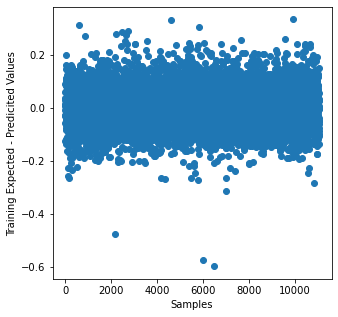

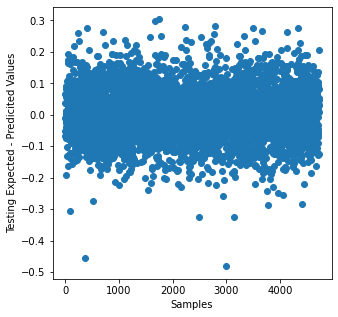

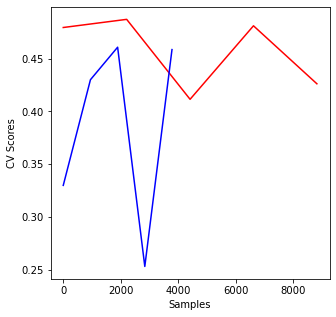

In [793]:
'''Using Random Forest with 70 Estimators as it is provided to be the best option for larger datasets'''

''''We will start by choosing features that represent few of of the current diseases the pateint could be suffering from'''


label = "hb"
features = ["leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide"]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

#We will stick to 70 estimators to avoid timely cross validations.

forest = RandomForestRegressor(n_estimators = 70, max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest.fit(train_x, train_y)
prediction = forest.predict(train_x)

error = mean_squared_error(prediction, train_y)
scores_tr = cross_val_score(forest, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = forest.predict(test_x)
scores_te = cross_val_score(forest, test_x, test_y, cv = 5)


print("Testing Score: ", np.average(scores_te))
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

It seems the accuracy is very high; however,the cross validation scross is still considerably low which means the model is overfitting and more data is needed.

# We will introduce part of the activities and diseases the patient could have to predict the hemoglobin level and check if overfitting is reduced.

Training Score:  0.7025309377559964
Training Error Margin:  0.002659204807364386
Training Accuracy:  0.9973407951926356

Testing Score:  0.6792474667804766
Testing Error Margin:  0.0031470706579361913
Testing Accuracy:  0.9968529293420638


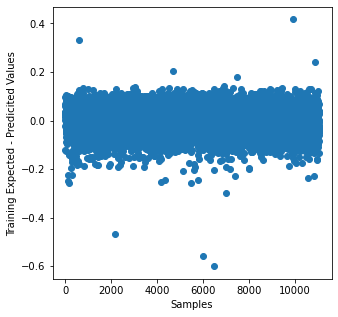

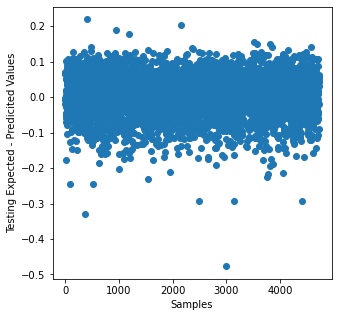

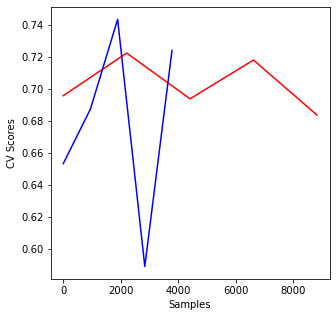

In [11]:
'''Again Using Random Forest with 70 Estimators as it is provided to be the best option for larger datasets'''

''''We will start by choosing features that represent few of of the current diseases the pateint could be suffering from'''

label = "hb"
features = ["leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide", "alcohol", "smoking ",
            "severe anaemia", "anaemia", "chronic kidney disease", "heart block", "sick sinus", "kidney injury", "hypertension",\
            "chronic kidney disease", "diabetes mellitus"]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

#We will stick to 70 estimators to avoid timely cross validations.

forest = RandomForestRegressor(n_estimators = 70, max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest.fit(train_x, train_y)
prediction = forest.predict(train_x)

error = mean_squared_error(prediction, train_y)
scores_tr = cross_val_score(forest, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = forest.predict(test_x)
scores_te = cross_val_score(forest, test_x, test_y, cv = 5)


print("Testing Score: ", np.average(scores_te))
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

We can see by adding more data the cross validation scores have been improved by almost 50% for both the training and testing datasets. We can also see the variations between the predicted and estimated values are shrinking towards zero which means the accuracy is increasing significanlty as the both are getting more identical.

# We will use more features regarding diseases the patient could be suffering from and their age and gender then checking scores and accuracy again. We will use XGBoost and pick also the best parameters for the data given.

Best Params:  {'alpha': 0.1, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10}
Best Score:  0.7358441847363445

Training Error:  0.0017328322159588065

Testing Error:  0.002647071421457147


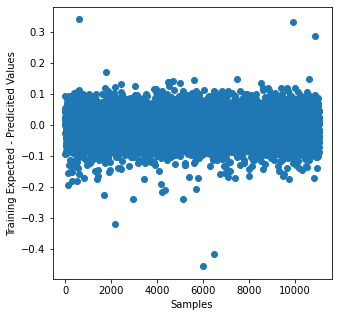

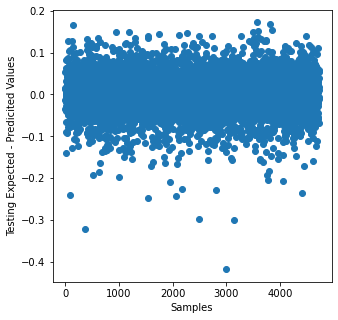

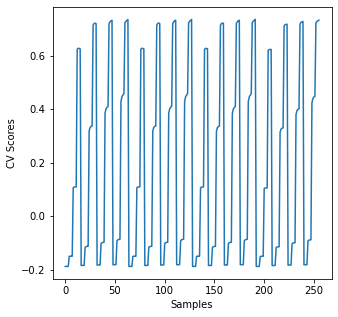

In [812]:
'''Using XGBoost'''

label = "hb"
features = ["heart failure", "stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",
            "coronary artery disease", "raised cardiac enzymes", "age", "gender", "glucose", "leucocyte count", "platelets", 
            "urea", "creatinine", "brain natriuretic peptide" ]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


xgb_classifier = xgb.XGBRegressor(objective = "reg:logistic", colsample_bytree = 0.1, learning_rate = 0.1,
                max_depth = 3, alpha = 1e-5, n_estimators = 70)


params = {"colsample_bytree" : [0.1, 0.3, 0.5, 0.7], "learning_rate" : [0.0001, 0.001, 0.01, 0.1], "max_depth" : [3, 5, 7, 10],
         "alpha" : [1e-5, 1e-3, 1e-1, 1]}

grid_search_cv = GridSearchCV(xgb_classifier, param_grid = params, n_jobs = -1, cv = 5)


result = grid_search_cv.fit(train_x, train_y)
print("Best Params: ", grid_search_cv.best_params_)
print("Best Score: ", grid_search_cv.best_score_ )
print()


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])


#References:
#https://www.datacamp.com/tutorial/xgboost-in-python

After picking the bet features that could boost the CV scor we can see that the best model chosen by teh grid search has a score 0.735 which slightly higher than the previous Random Forest model that had less data to process. The variance between the predicted and estimated values also remains almost identical indicating that the output precision is barely improving.

In [43]:
'''Converting the numerical/continuous features original values to log'''

names = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
         "ejection fraction", "duration of intensive unit stay"]

original_vals = np.array(original_vals, dtype = "float64")

log_vals = list()
temp_data = list()

for i in range(len(original_vals)):
    for j in range(len(original_vals[i])):
        
        if original_vals[i][j] <= 0:
            temp_data.append(0)
            
        else:
            temp_data.append(np.log(np.array(original_vals[i][j], dtype = "float64")))
            
    log_vals.append(temp_data.copy())
    data.loc[:, names[i]] = temp_data.copy()
    temp_data.clear()
            
data[names].head(3)

,hb,leucocyte count,platelets,glucose,urea,creatinine,brain natriuretic peptide,ejection fraction,duration of intensive unit stay
0,2.251292,2.778819,5.820083,4.382027,3.526361,-0.105361,7.539027,3.555348,0.693147
1,2.617396,2.197225,5.003946,4.718499,2.890372,-0.105361,0.000000,3.737670,0.693147
2,2.360854,2.687847,5.796058,5.231109,4.532599,0.832909,5.347108,0.000000,1.098612


Training Score:  0.8586820513573951
Training Error:  0.006878715344523183

Testing Score:  0.8355006134173386
Testing Error:  0.014814113026796433


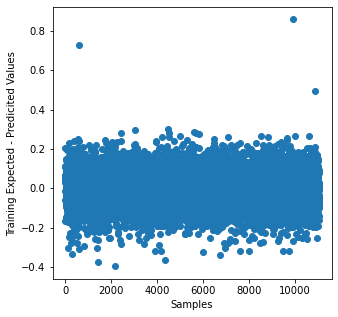

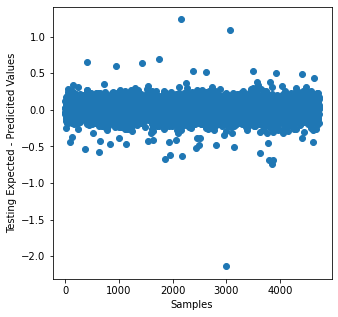

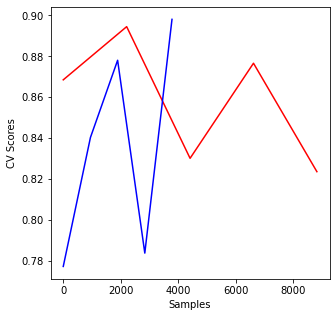

In [837]:
'''Using XGBoost with log values'''


label = "hb"

features = ["heart failure", "stable angina", "acs", "myocardial infarction", "atypical chest pain", "cerebrovascular accident",
            "atrial fibrillation", "ventricular tachycardia", "paroxysmal tachycardia", "congenital", "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction",
            "heart block", "sick sinus", "kidney injury", "hypertension", "chronic kidney disease",
            "diabetes mellitus", "infective endocarditis", "vein thrombosis", "cardiogenic shock", "pulmonary embolism",
            "coronary artery disease", "raised cardiac enzymes", "age", "gender", "glucose", "leucocyte count", "platelets", 
            "urea", "creatinine", "brain natriuretic peptide" ]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


'''We will use the best parameters selected from the grid search in the previous XGBoost model to minimize escessive 
   check-ups'''

xgb_classifier = xgb.XGBRegressor( colsample_bytree = 0.7, learning_rate = 0.1,
                max_depth = 10, alpha = 0.1, n_estimators = 70)



result = xgb_classifier.fit(train_x, train_y)

scores_tr = cross_val_score(xgb_classifier, train_x, train_y, cv = 5)
print("Training Score: ", np.average(scores_tr))


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

scores_te = cross_val_score(xgb_classifier, test_x, test_y, cv = 5)
print("Testing Score: ", np.average(scores_te))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

We can see after using the log values of the continuous data we gained a significant increase of almost 10% for the training data CV score and remained aboved 0.84 for the testing score which is also further illustarted the shrinkage of the variations in between the predicted and expected values above.

The CV score graph is also showing us during training and testing, the CV score has reachead a maximum of approximatley 0.9 which is about 0.17 from the achieved best score though the previous model grid searching

It is worth noting that through manual check-up anemia has the biggest effect of the model predictibility of hemoglobin as linsk directly to blood disorders and low red blood cells where hemoglobin is where it contributes to about 0.2 of CV scores. Other features also have some considerable effect on the predictibility like leucocyte count and platelets which also link direclty to 
white blood and blood clotting; furthermore, age and gender played a slight role in the prediction process where they jointly contributed to about 0.03 boost in CV scores. Other features contributed less than 0.03 boost in CV scores separatley and provided a noticable reduction in error margins.

In [184]:
'''Re-using the normalized data'''

names = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
        "ejection fraction", "duration of intensive unit stay"]

for i in range(len(names)):
    data.loc[:, names[i]] = stand_vals[i]

# We will classify patients regarding the type of admission needed with each of their health info of current diseases, activities and blood tests.

# We will start by building an effecient SVC model, then compare the results to XGBoost and   K-neighbours algorithims.

In [7]:
label = "type of admission-emergency/opd"

unique_labels, counts = np.unique(data[label].values, return_counts = True)
admissions = ["Emergency","Outpatient"]

print("Different Admission Types: ", unique_labels)
print()

for u in range(len(unique_labels)):
    print(f"Admission Type {unique_labels[u]} is: ", admissions[u])
    print("Count: ", counts[u])
    print()
    
    
'''We will try determing the type of admission using patients blood tests first'''

features = ["hb", "leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide"]

Different Admission Types:  ['E' 'O']

Admission Type E is:  Emergency
Count:  10924

Admission Type O is:  Outpatient
Count:  4833



In [ ]:
'''Constructing the Linear SVC model'''

data.loc[:,label] = LabelEncoder().fit_transform(data[label].values)


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

svc_classifier = svm.SVC(C = 1, kernel = "linear", gamma = "scale")

'''It was checked manually that the algorithim is favoring only positive large C values.'''

params = {"C" : [1e9, 1e7, 1e5]}

grid_search_cv = GridSearchCV(svc_classifier, param_grid = params, n_jobs = -1, cv = 5)
result = grid_search_cv.fit(train_x,train_y)

Best Model Parameters:  {'C': 100000.0}
Best Model Score:  0.6908151135945463

Training Error Margin:  0.30918487623537944
Testing Error Margin:  0.3009729272419628


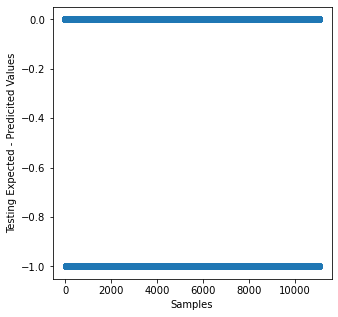

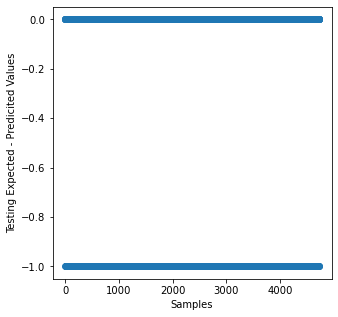

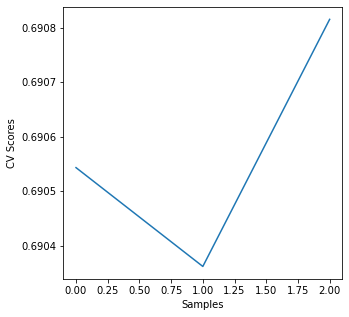

In [91]:
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)


print("Best Model Parameters: ", grid_search_cv.best_params_)
print("Best Model Score: ", grid_search_cv.best_score_)
print()


print("Training Error Margin: ", error)
plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)

print("Testing Error Margin: ", error)
plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])

As illustarted above we can see that we are achieving a reasonable CV score and error margin considering the few features given which indicates the high posibbility of enhancing the results as more data are provided.

# We introduce age, gender, and some of the diseases and activities to the data that the patient could have.

Training Score:  0.6908151135945463
Training Error:  0.30918487623537944

Testing Score:  0.6990272604226092
Testing Error:  0.3009729272419628


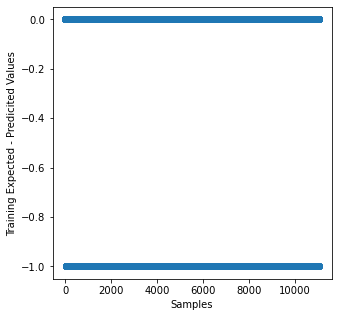

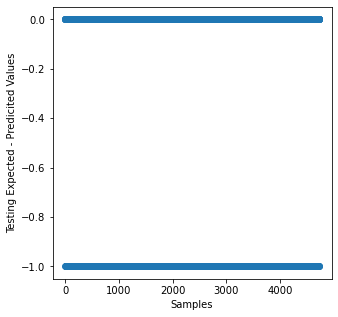

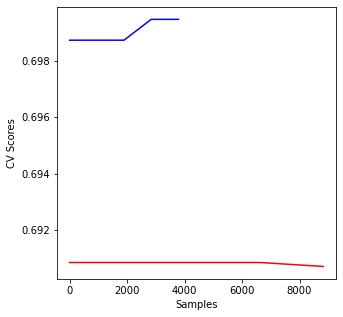

In [19]:
'''Using SVC linear model with C = 1e5 as it is the best chosen parameter from the previous grid search'''


data.loc[:, label] = LabelEncoder().fit_transform(data[label].values)

features = ["hb", "leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide",  "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "kidney injury", "hypertension",
            "age", "gender", "glucose"]

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

svc_classifier = svm.SVC(C = 1e5, kernel = "linear", gamma = "scale")

result = svc_classifier.fit(train_x, train_y)


scores_tr = cross_val_score(svc_classifier, train_x, train_y, n_jobs = -1, cv = 5)
print("Training Score: ", np.average(scores_tr))


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

scores_te = cross_val_score(svc_classifier, test_x, test_y, n_jobs = -1, cv = 5)
print("Testing Score: ", np.average(scores_te))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

We can see by adding more featues the CV scores and margin of error haven't chnages which means the extra data provided are adding any gain in affecting the predictibility of type of admission-emergency/opd; furthermore, this means there is a significant bias between the type of admission-emergency/opd and very specific feature(s) that we have to look for manually.

Training Score:  0.7343366576004835
Training Error:  0.26421253060114247

Testing Score:  0.7459791715605669
Testing Error:  0.2540186125211506


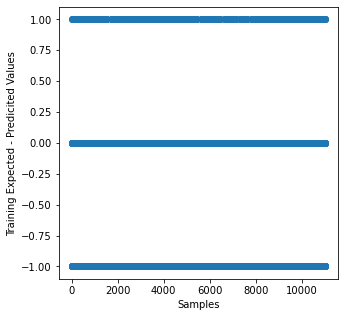

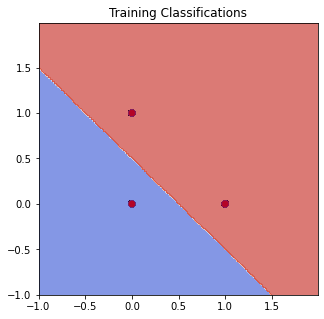

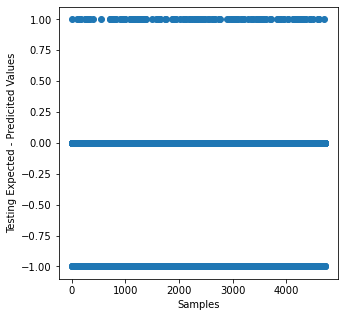

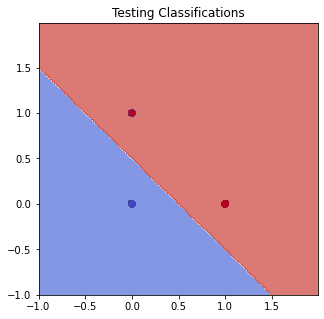

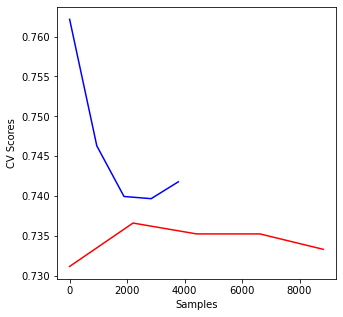

In [844]:
'''After looking in depth into the data and with trial and error, patients with hear failure or not can perfectly predict
   whether they are an emergency patient or an outpatient as shown below'''

'''We will use the same SVC model'''


label = "type of admission-emergency/opd"

data.loc[:,label] = LabelEncoder().fit_transform(data[label].values)

features = ["stable angina", "atypical chest pain"]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

svc_classifier = svm.SVC(C = 1e5, kernel = "linear", gamma = "scale")

result = svc_classifier.fit(train_x, train_y)


scores_tr = cross_val_score(svc_classifier, train_x, train_y, n_jobs = -1, cv = 5)
print("Training Score: ", np.average(scores_tr))


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

train_x_min, train_x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
train_y_min, train_y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
x, y = np.meshgrid(np.arange(train_x_min, train_x_max, 1e-2), np.arange(train_y_min, train_y_max, 1e-2))

z = result.predict(np.c_[x.ravel(), y.ravel()])
z = z.reshape(x.shape)

plt.subplots(1, figsize = (5,5))
plt.title("Training Classifications")
plt.contourf(x, y, z, cmap = plt.cm.coolwarm, alpha= 0.7)
plt.scatter(train_x[:, 0], train_x[:, 1], c = train_y, cmap = plt.cm.coolwarm)


scores_te = cross_val_score(svc_classifier, test_x, test_y, n_jobs = -1, cv = 5)
print("Testing Score: ", np.average(scores_te))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))

test_x_min, test_x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
test_y_min, test_y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
x, y = np.meshgrid(np.arange(test_x_min, test_x_max, 1e-2), np.arange(test_y_min, test_y_max, 1e-2))

z = result.predict(np.c_[x.ravel(), y.ravel()])
z = z.reshape(x.shape)

plt.subplots(1, figsize = (5,5))
plt.title("Testing Classifications")
plt.contourf(x, y, z, cmap = plt.cm.coolwarm, alpha = 0.7)
plt.scatter(test_x[:, 0], test_x[:, 1], c = test_y, cmap=plt.cm.coolwarm)

plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

#References:
#https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

After trying with multiple features, it seems patient having stable angina, atypical chest pain or not are the best indicator if they should be put in an emergency or not. The CV score have increases by about 0.04 for the training data test and 0.05 for the testing data ash shown above; however we can still see a peak of about 0.765 for the testing data which is about 0.06 up from the previous model and 0.045 for the training data.

The variations between the predicted data and the expected data for both training and testing datsest it seems to be finding more correct predictions based on the lower error margin and graphs by having more predictins lie within the zero range and fewer liying at 1 and -1 values which improves the total accuracy.

The classification graphs are added to illustrate the labels and missclassifications further where we can see that there are few classes classified as 0 where they should be classified as 1 and vise-versa for both training and testing datasets.

Best Parameter: {'degree': 2}
Best Parameter Score:  0.7343366576004835

Best Parameter Training Error Margin:  0.26421253060114247

Best Parameter Testing Error Margin:  0.2540186125211506


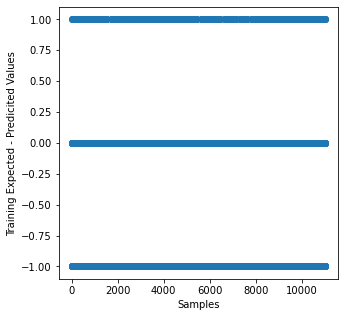

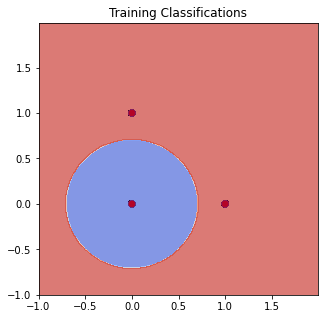

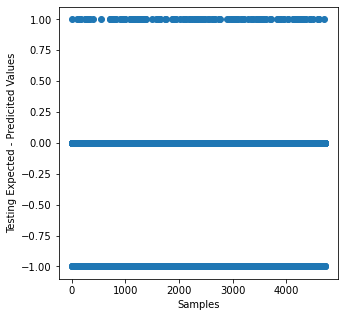

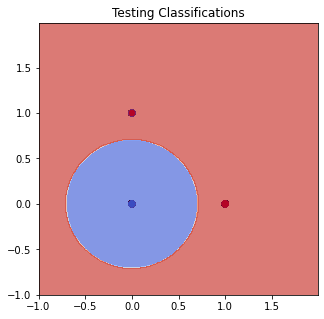

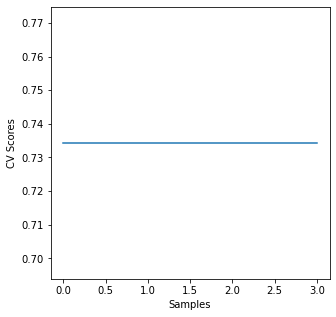

In [141]:
'''Using Polynomial SVR'''

svc_classifier = svm.SVC(C = 1e5, kernel = "poly", degree = 2, gamma = "scale")

params = {"degree" : [2, 3, 4, 5]}

grid_search_cv = GridSearchCV(svc_classifier, param_grid = params, n_jobs = -1, cv = 5)
result = grid_search_cv.fit(train_x,train_y)
prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)

print("Best Parameter:", grid_search_cv.best_params_)
print("Best Parameter Score: ", grid_search_cv.best_score_)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


train_x_min, train_x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
train_y_min, train_y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
x, y = np.meshgrid(np.arange(train_x_min, train_x_max, 1e-2), np.arange(train_y_min, train_y_max, 1e-2))

z = result.predict(np.c_[x.ravel(), y.ravel()])
z = z.reshape(x.shape)

plt.subplots(1, figsize = (5,5))
plt.title("Training Classifications")
plt.contourf(x, y, z, cmap = plt.cm.coolwarm, alpha= 0.7)
plt.scatter(train_x[:, 0], train_x[:, 1], c = train_y, cmap = plt.cm.coolwarm)


print("Best Parameter Training Error Margin: ", error)
print()

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Best Parameter Testing Error Margin: ", error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


test_x_min, test_x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
test_y_min, test_y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
x, y = np.meshgrid(np.arange(test_x_min, test_x_max, 1e-2), np.arange(test_y_min, test_y_max, 1e-2))

z = result.predict(np.c_[x.ravel(), y.ravel()])
z = z.reshape(x.shape)

plt.subplots(1, figsize = (5,5))
plt.title("Testing Classifications")
plt.contourf(x, y, z, cmap = plt.cm.coolwarm, alpha = 0.7)
plt.scatter(test_x[:, 0], test_x[:, 1], c = test_y, cmap=plt.cm.coolwarm)

plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])



When using polynomial SVC model with degree 2 it seems the model is generating idential results with the linear one regarding error margins and CV scores.

The classification graphs are added to illustrate the labels and missclassifications further where we can see that there are few classes classified as 0 where they should be classified as 1 and vise-versa for both training and testing datasets.

Best Params:  {'alpha': 1e-05, 'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 3}
Best Score:  -0.24088729184240223

Training Error:  0.2655725813763714

Testing Error:  0.2569796954314721


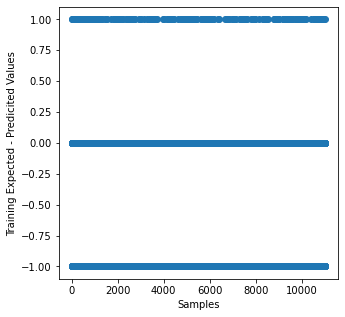

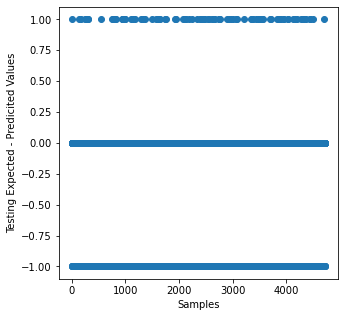

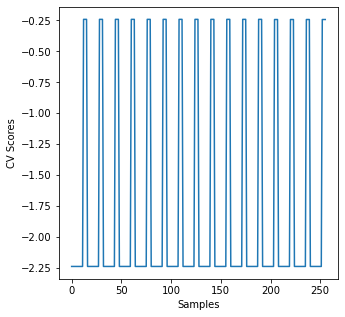

In [22]:
'''Using XGBoost with the same features in the previous model'''

label = "type of admission-emergency/opd"

data.loc[:,label] = LabelEncoder().fit_transform(data[label].values)

features = ["stable angina", "atypical chest pain"]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)

xgb_classifier = xgb.XGBRegressor( objective = "binary:hinge", colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 1, n_estimators = 70)


params = {"colsample_bytree" : [0.1, 0.3, 0.5, 0.7], "learning_rate" : [0.0001, 0.001, 0.01, 0.1], "max_depth" : [3, 5, 7, 10],
         "alpha" : [1e-5, 1e-3, 1e-1, 1]}

grid_search_cv = GridSearchCV(xgb_classifier, param_grid = params, n_jobs = -1, cv = 5)


result = grid_search_cv.fit(train_x, train_y)
print("Best Params: ", grid_search_cv.best_params_)
print("Best Score: ", grid_search_cv.best_score_ )
print()


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])


#References:
#https://www.datacamp.com/tutorial/xgboost-in-python

As seen above XGBoost isn't the perfect model for predicting the type of admission-emergency/opd of the patient as the CV score is significantly lower than the linear SVC model despite the almost identical error margins which is indicating that severe overfitting is occuring with missclassifications.

Best Params:  {'algorithm': 'brute', 'n_neighbors': 500, 'weights': 'distance'}
Best Score:  0.09316886840888072

Training Error:  0.19382121679607905
Training Expected and Classes Counts:  (array([0, 1], dtype=int64), array([7619, 3410], dtype=int64))
Training Predicted and Classes Counts:  (array([0.236     , 0.52747253, 0.758     ]), array([9855,  273,  901], dtype=int64))

Testing Error:  0.18863240896134156
Testing Expected Classes and Counts:  (array([0, 1], dtype=int64), array([3305, 1423], dtype=int64))
Testing Predicted Classes and Counts:  (array([0.236     , 0.52556723, 0.758     ]), array([4210,  130,  388], dtype=int64))


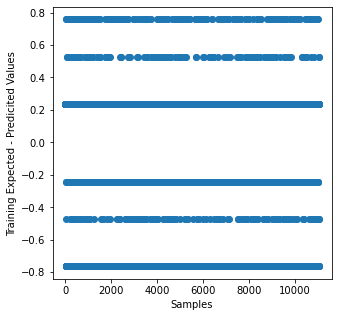

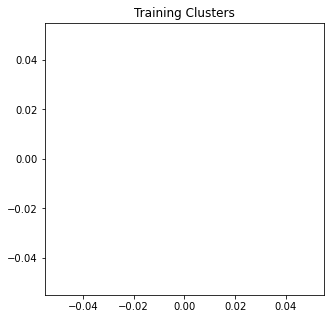

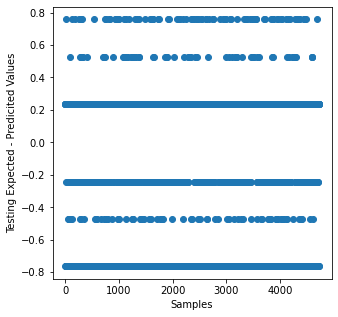

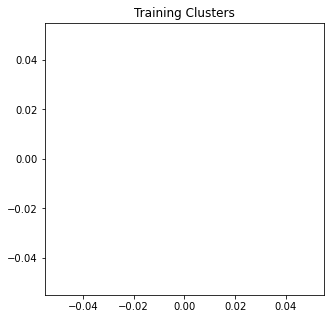

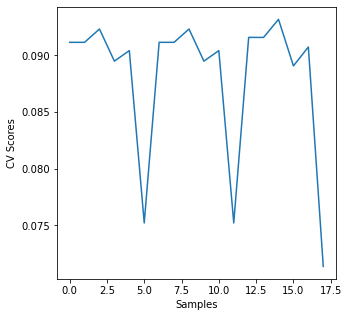

In [47]:
'''Using KNeighborsRegressor'''

neighbors_classifier = KNeighborsRegressor(n_neighbors = 100, weights = "distance", algorithm = "kd_tree", leaf_size = 30)

tr_x_pca = PCA(2).fit_transform(train_x)
te_x_pca = PCA(2).fit_transform(test_x)

params = {"n_neighbors" : [100, 500, 900], "weights" : ["distance", "uniform"], "algorithm" : ["ball_tree",\
          "kd_tree", "brute"]}

grid_search_cv = GridSearchCV(neighbors_classifier, param_grid = params, n_jobs = -1, cv = 3)

result = grid_search_cv.fit(tr_x_pca, train_y)
prediction = result.predict(tr_x_pca)


print("Best Params: ", grid_search_cv.best_params_)
print("Best Score: ", grid_search_cv.best_score_)
print()

prediction = result.predict(tr_x_pca)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print("Training Expected and Classes Counts: ", np.unique(train_y, return_counts = True))
print("Training Predicted and Classes Counts: ", np.unique(prediction, return_counts = True))
print()

plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(tr_x_pca)), np.array(prediction - train_y))

plt.subplots(1, figsize = (5,5))
plt.title("Training Clusters")
plt.plot(tr_x_pca[prediction == 0][:,0], tr_x_pca[prediction == 0][:, 1])
plt.plot(tr_x_pca[prediction == 1][:,0], tr_x_pca[prediction == 1][:, 1])


prediction = result.predict(te_x_pca)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)
print("Testing Expected Classes and Counts: ", np.unique(test_y, return_counts = True))
print("Testing Predicted Classes and Counts: ", np.unique(prediction, return_counts = True))


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(te_x_pca)), np.array(prediction - test_y))

plt.subplots(1, figsize = (5,5))
plt.title("Training Clusters")
plt.plot(te_x_pca[prediction == 0][:,0], te_x_pca[prediction == 0][:, 1])
plt.plot(te_x_pca[prediction == 1][:,0], te_x_pca[prediction == 1][:, 1])



plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])


#References:
#https://www.askpython.com/python/examples/plot-k-means-clusters-python

Training Score:  0.7357872469023874
Training Error:  0.26421253060114247
Training Expected and Classes Counts:  (array([0, 1], dtype=int64), array([7619, 3410], dtype=int64))
Training Predicted and Classes Counts:  (array([0, 1], dtype=int64), array([9855, 1174], dtype=int64))

Testing Score:  0.7459791715605669
Testing Error:  0.2540186125211506
Testing Expected Classes Counts:  (array([0, 1], dtype=int64), array([3305, 1423], dtype=int64))
Testing Predicted Classes Counts:  (array([0, 1], dtype=int64), array([4210,  518], dtype=int64))


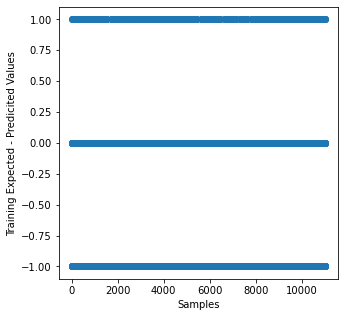

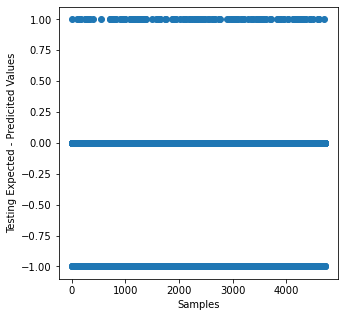

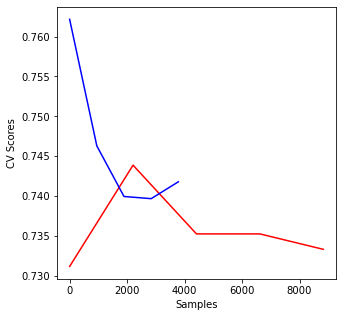

In [46]:
'''Using Naive Bayes'''

naive_bayes = GaussianNB()


result = naive_bayes.fit(train_x, train_y)
prediction = result.predict(train_x)


scores_tr = cross_val_score(naive_bayes, train_x, train_y, n_jobs = -1, cv = 5)
print("Training Score: ", np.average(scores_tr))


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print("Training Expected and Classes Counts: ", np.unique(train_y, return_counts = True))
print("Training Predicted and Classes Counts: ", np.unique(prediction, return_counts = True))
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


scores_te = cross_val_score(naive_bayes, test_x, test_y, n_jobs = -1, cv = 5)
print("Testing Score: ", np.average(scores_te))

prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)
print("Testing Expected Classes Counts: ", np.unique(test_y, return_counts = True))
print("Testing Predicted Classes Counts: ", np.unique(prediction, return_counts = True))


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

Using Kneighbours to predict type of stay of the patient by clustering emrgency and outpatients in 2 different clusters proved ineffecient as the variations between the data is minimzed because the values consisits of zeroes and ones; furthermore, to solve this issue, we tried using PCA of the best 2 components to create effecient variations for clustering; however, this is also rendered useless. The CV scores are illustarting significant overfitting. From the graph we can also see that the model fails in constructing two cluster for 0s and 1s. 

In conclusion, SVC linear, polynomial model (degree 2) and Naive Bayes generated best results regarding consistency of outputs and reduction of overfitting where all error margins and CV score were almost identical.

It is worth noting that through manual check-up, stable angine feature tend to mostly provide the increae in CV scores with about 0.7 boost alone which indicates there is a high chance in predicting if patient needs to go the emergency room in case their bodies don't have enough oxygen for the heart to pump which generates chest pain, this is usually caused by an underlying heart disease.

Atypical chest pain feature is also linked to predicting the patient's type of admission as it is a main symptom of stable angina and it usually contributes to 0.03 boost in CV scores. Other features were omitted ater the initial check-up as they contributed 0 boost in CV score and error margins.

# We will try to predict if a patient has coronary artery disease using Neural Network, Random Forest and XGBoost.

Best Paramater:  {'model__dropout_rate': 0.1, 'model__reg_val': 1e-05}
Best Score:  0.7334300392867936

Training Error Margin:  0.24127300752561429
Training Accuracy:  0.7587269924743857

Testing Error Margin:  0.25972927241962773
Testing Accuracy:  0.7402707275803723


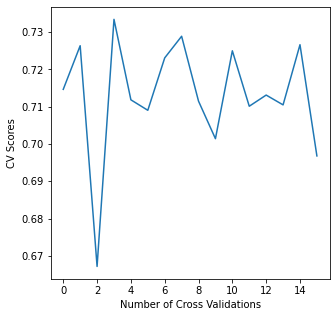

In [161]:
label = "coronary artery disease"

'''Using patients' age, gender, blood tests, few of their diagnosed diseases and activities first'''

features = ["hb", "leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide",  "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "kidney injury", "hypertension",
            "age", "gender", "glucose"]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network(dropout_rate = 0, reg_val = 0):
    
    '''A structure of 4 dense layer and 100 nodes will be used again as it proved its effecien to gain near maximally acurrate
       results and with low overfitting in previous models and to save processing time.'''
    
    layers = tf.keras.Sequential()
    
    layers.add(tensor_normalizer)
    
    layers.add(Dense(100, activation = "relu",\
           activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(reg_val)))
    layers.add(Dropout(dropout_rate))

    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "accuracy" )
    
    return layers

'''Epcohs and batch size will be fixed at 70 and 100 as they proved to be the most viable options on previous models and to 
   save processing time.'''

tf_classifier = KerasClassifier(model = run_network, epochs = 70, batch_size = 100, verbose = 0)

params = {"model__dropout_rate" : [1e-1, 1e-3, 1e-5, 1e-7], "model__reg_val" : [1, 1e-1, 1e-3, 1e-5]}

grid_search = GridSearchCV(estimator = tf_classifier, param_grid = params, cv = 5, verbose = 0)
fitting = grid_search.fit(train_x, train_y)

print("Best Paramater: ", fitting.best_params_)
print("Best Score: ", fitting.best_score_)
print()

prediction = grid_search.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)

print()
prediction = grid_search.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize=(5,5))
plt.ylabel("CV Scores")
plt.xlabel("Number of Cross Validations")
plt.plot(np.arange(0, len(fitting.cv_results_["mean_test_score"])), fitting.cv_results_["mean_test_score"])

Initially we can see that we have achieved a significant CV score and error margin considering the low amount of features used which means there is a good chance in improving our results as more data is  provided.

It is also worth noting that the regularization and dropout paraneters remain the same from the prior model.

Training Error Margin:  0.21062653005712212
Training Accuracy:  0.7893734699428778
Training Score:  0.7424966335884611

Testing Error Margin:  0.25761421319796957
Testing Accuracy:  0.7423857868020305
Testing Score:  0.7286439142253095


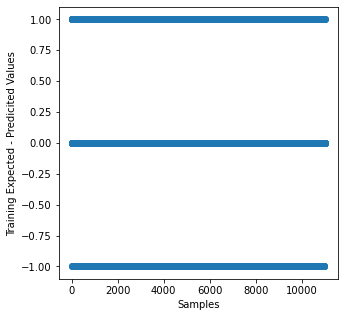

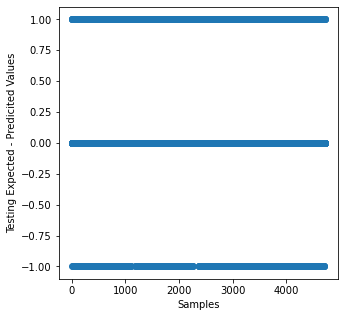

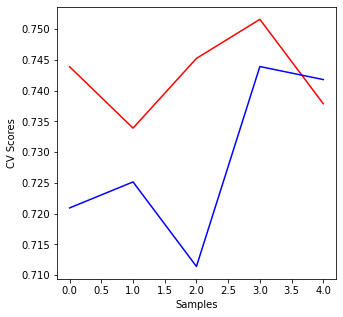

In [8]:
'''We will add further features and compare accuracy'''

label = "coronary artery disease"

'''Using patients' age, gender, blood tests, few of diagonosed diseases and activities first'''


features = ["hb", "leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide",  "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "kidney injury", "hypertension",
            "age", "gender", "glucose", "urinary tract infections",  "diabetes mellitus",
            "prior metabolic panel", "sick sinus", "pulmonary embolism", "vein thrombosis", "orthostatic",
            "raised cardiac enzymes", "infective endocarditis", "neuro cardiogenic syncope", "cerebrovascular accident"]

data.loc[:,"gender"] = LabelEncoder().fit_transform(data["gender"])

train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network():
    
    '''A structure of 4 dense layer and 100 nodes will be used again as it proved its effecien to gain near maximally acurrate
       results and with low overfitting in previous models and to save processing time.'''
    
    layers = tf.keras.Sequential()
    
    layers.add(tensor_normalizer)
    
    layers.add(Dense(100, activation = "relu",\
           activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "accuracy" )
    
    return layers

'''Epochs and batch size will be fixed at 70 and 100 as they proved to be the most viable options on previous models and to 
   save processing time.'''

tf_classifier = KerasClassifier(model = run_network, epochs = 70, batch_size = 100, verbose = 0)

result = tf_classifier.fit(train_x, train_y)
prediction = tf_classifier.predict(train_x)
error = mean_squared_error(prediction, train_y)

print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

scores_tr = cross_val_score(tf_classifier, train_x, train_y, cv = 5)
print("Training Score: ", np.average(scores_tr))
print()


prediction = tf_classifier.predict(test_x)

error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))

scores_te = cross_val_score(tf_classifier, test_x, test_y, cv = 5)
print("Testing Score: ", np.average(scores_te))

plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(scores_te)), scores_te, color = "blue")

With adding more features we can see a boost in CV scores and accuracy of the network where the error margin was reduced by about 2% for the training dataset and about 0.4% - 0.7% for the testing dataset. The CV score is boosted by approximatley 0.1% also.

Training Score:  0.7494784991663634
Training Error Margin:  0.17327046876416718
Training Accuracy:  0.8267295312358328

Testing Score:  0.7459867780798014
Testing Error Margin:  0.24323181049069373
Testing Accuracy:  0.7567681895093062


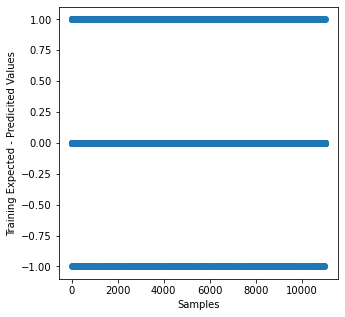

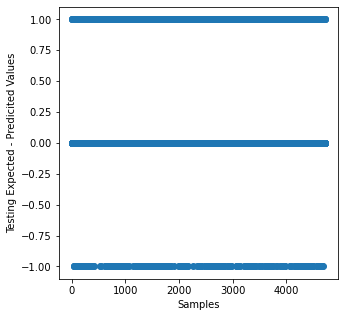

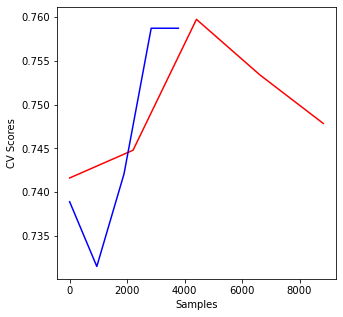

In [9]:
'''Using Random Foests'''

'''Again Using Random Forest with 70 Estimators as it is provided to be the best option for larger datasets'''


forest = RandomForestClassifier(n_estimators = 70, max_depth = 10, n_jobs = -1, random_state = 1337)
result = forest.fit(train_x, train_y)
prediction = forest.predict(train_x)

error = mean_squared_error(prediction, train_y)
scores_tr = cross_val_score(forest, train_x, train_y, cv = 5)

print("Training Score: ", np.average(scores_tr))
print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = forest.predict(test_x)
scores_te = cross_val_score(forest, test_x, test_y, cv = 5)


print("Testing Score: ", np.average(scores_te))
error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(train_x), len(train_x) / len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(test_x), len(test_x) / len(scores_te)), scores_te, color = "blue")

Best Params:  {'alpha': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10}
Best Score:  -0.13441163848342472

Training Error:  0.08341644754737511

Testing Error:  0.24196277495769883


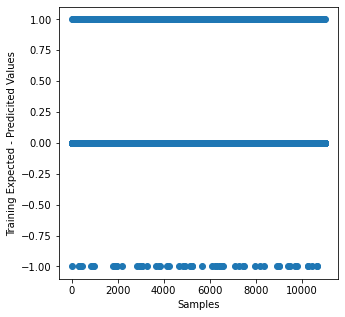

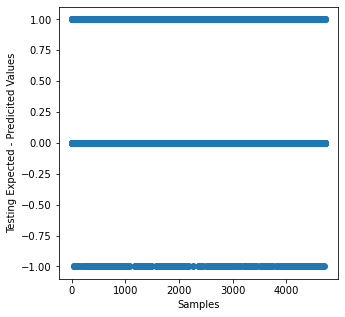

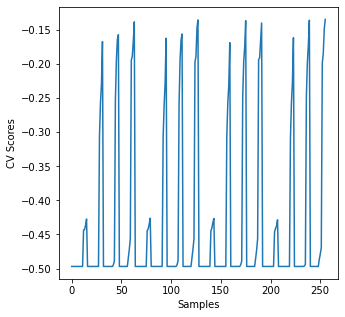

In [18]:
'''Using XGBoost'''

xgb_classifier = xgb.XGBRegressor(objective = "binary:hinge",colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 1, n_estimators = 70)


params = {"colsample_bytree" : [0.1, 0.3, 0.5, 0.7], "learning_rate" : [0.0001, 0.001, 0.01, 0.1], "max_depth" : [3, 5, 7, 10],
         "alpha" : [1e-5, 1e-3, 1e-1, 1]}

grid_search_cv = GridSearchCV(xgb_classifier, param_grid = params, n_jobs = -1, cv = 5)


result = grid_search_cv.fit(train_x, train_y)
print("Best Params: ", grid_search_cv.best_params_)
print("Best Score: ", grid_search_cv.best_score_ )
print()


prediction = result.predict(train_x)
error = mean_squared_error(prediction, train_y)
print("Training Error: ", error)
print()


plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))


prediction = result.predict(test_x)
error = mean_squared_error(prediction, test_y)
print("Testing Error: ", error)


plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))


plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0, len(grid_search_cv.cv_results_["mean_test_score"])), grid_search_cv.cv_results_["mean_test_score"])

We can see that neural netwroks are superior to both random forests and XGBoost when predicting the if the patient has coronary artery disease. The overfitting in XGBoost is highly significant despite the low training error margins; furthermore, the low CV scores clarify the overfitting and the occured misclassification of data compared to the label vector.

In [ ]:
'''We will try to boost the accuracy of the netwrok by using the log values of the provided blood test as follows'''

names = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide"]

for i in range(len(names)):
    data.loc[:, names[i]] = log_vals[i]

Training Error Margin:  0.2087224589718016
Training Accuracy:  0.7912775410281984
Training Score:  0.7443097057499337

Testing Error Margin:  0.2521150592216582
Testing Accuracy:  0.7478849407783418
Testing Score:  0.7387943667013435


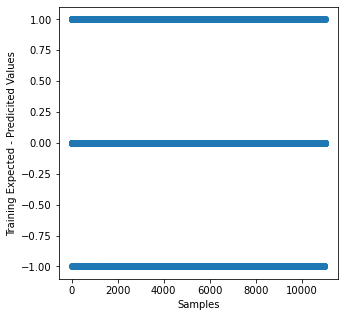

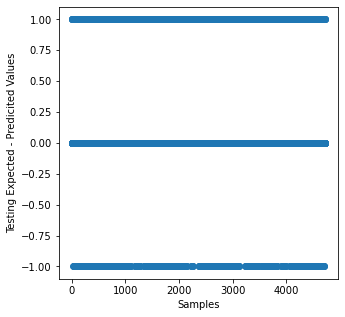

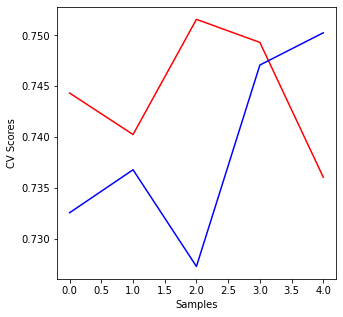

In [188]:
'''Re-using the previous neural netwrok model to re-check accuracy'''

label = "coronary artery disease"

features = ["hb", "leucocyte count", "platelets", "urea",  "creatinine", "brain natriuretic peptide",  "smoking ",
            "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "kidney injury", "hypertension",
            "age", "gender", "glucose", "urinary tract infections",  "diabetes mellitus",
            "prior metabolic panel", "sick sinus", "pulmonary embolism", "vein thrombosis", "orthostatic",
            "raised cardiac enzymes", "infective endocarditis", "neuro cardiogenic syncope", "cerebrovascular accident"]


train_x, test_x, train_y, test_y = train_test_split(data[features].values, data[label].values, test_size = 0.3,\
                                                    random_state = 1337)


data_tensor = tf.convert_to_tensor(train_x)
tensor_normalizer = tf.keras.layers.Normalization(axis = -1)
tensor_normalizer.adapt(data_tensor)

def run_network():
    
    layers = tf.keras.Sequential()
    
    layers.add(tensor_normalizer)
    
    layers.add(Dense(100, activation = "relu",\
           activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(100, activation = "relu",\
                        activity_regularizer = regularizer.L2(1e-5)))
    layers.add(Dropout(0.1))

    layers.add(Dense(1))

    layers.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "accuracy" )
    
    return layers


tf_classifier = KerasClassifier(model = run_network, epochs = 70, batch_size = 100, verbose = 0)

result = tf_classifier.fit(train_x, train_y)
prediction = tf_classifier.predict(train_x)
error = mean_squared_error(prediction, train_y)

print("Training Error Margin: ", error)
print("Training Accuracy: ", 1 - error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Training Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(train_x)), np.array(prediction - train_y))

scores_tr = cross_val_score(tf_classifier, train_x, train_y, cv = 5)
print("Training Score: ", np.average(scores_tr))
print()


prediction = tf_classifier.predict(test_x)

error = mean_squared_error(prediction, test_y)
print("Testing Error Margin: ", error)
print("Testing Accuracy: ", 1 - error)

plt.subplots(1, figsize = (5,5))
plt.ylabel("Testing Expected - Predicited Values")
plt.xlabel("Samples")
plt.scatter(np.arange(0 , len(test_x)), np.array(prediction - test_y))

scores_te = cross_val_score(tf_classifier, test_x, test_y, cv = 5)
print("Testing Score: ", np.average(scores_te))

plt.subplots(1, figsize = (5,5))
plt.ylabel("CV Scores")
plt.xlabel("Samples")
plt.plot(np.arange(0,len(scores_tr)), scores_tr, color = "red")
plt.plot(np.arange(0,len(scores_te)), scores_te, color = "blue")

By using the log value of some of the bloodtests used, we can see a slight boost in the tarining accuracy but the testing accuracy remains almost the same. The CV scores for both training and testing datasets are bosted by 1-2% which shows slight overfitting reduction.

In coclusion, we can say that neural network is the best model tested among the Random Forests and XGBoost through achieving lower overfittingand more concise predicted data compared to the expected data. 
The accuracy can still be boosted by introducing features that confirms the pateint has a heart disease; however, we are trying to make the results as authentic and generalized as possible.


It is worth noting that through manual check-up, hypertension contributed the most in predicting if a patient has coronory artery disease by contributing about 0.1 increase in CV scores which indicates high blood pressure has a strong link to  coronory artery disease.

brain natriuretic peptide contributed about 0.03 boost in CV scores boost when predicitng if a patient has coronory artery disease as it is the main substanc produced by the heart that its levels show if teh patient might have a heart failure/disease or not. Features like age and gender provided a boost less 0.04 for the CV scores and other provided feature were mostly linked to heart diseases, blood clotting and inflamations to further enhance the prediction results based on patient overall immunity system and heart and brain health.

In [191]:
'''Re-using normalized data'''

names = ["hb", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide"]

for i in range(len(names)):
    data.loc[:, names[i]] = stand_vals[i]